# HCDN Elevation Analysis
# Daniel Hogan - Summer 2023

This notebook will work to look at changes in the streamflow center of mass timing, streamflow volume, seasonal precipitation and annual precipitation between periods in different elevation bands across the UCRB.

In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import rioxarray as rxr

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
%matplotlib inline

### Import data 

In [3]:
# import UCRB boundaries
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

In [4]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')
# these two basins are especially difficult since they are small and extremely flashy and ephemeral. the last basin ended its record in the early 2000s
bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630']) 
hcdn_basins = hcdn_basins[~bad_gages]
hcdn_basins = hcdn_basins.set_crs(epsg='32613', allow_override=True)

In [5]:
# HCDN seasonal precipitation
hcdn_seasonal_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.sel(dim_1='ppt')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.rename({'__xarray_dataarray_variable__':'ppt','variable':'site_no'})
hcdn_seasonal_ppt = hcdn_seasonal_ppt.where(~hcdn_seasonal_ppt.site_no.isin(['09306242','09378170','09378630']),drop=True)
hcdn_seasonal_ppt['year'] = hcdn_seasonal_ppt.month.dt.year.where(hcdn_seasonal_ppt.month.dt.month<10, hcdn_seasonal_ppt.month.dt.year+1)
hcdn_annual_ppt = hcdn_seasonal_ppt.groupby('year').sum()

# Daily and annual HCDN streamflow and basin characteristics
hcdn_daily_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_chars_and_daily_q.nc')
hcdn_annual_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc').drop('dim_1')
# rename the year dimension to WY
hcdn_annual_ppt_2 = hcdn_annual_ppt.rename({'year': 'WY'})
# add ppt to the annual streamflow dataset
hcdn_annual_q = hcdn_annual_q.merge(hcdn_annual_ppt_2.sel(WY=slice(1902,2022)).ppt)

# UCRB monthly precipitation
prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
prism_4km_all_ds = prism_4km_all_ds.rename({'__xarray_dataarray_variable__':'ppt'})
p_mean = prism_4km_all_ds.where(prism_4km_all_ds>0).mean(dim=['x','y'])
p_mean['WY'] = p_mean.month.dt.year.where(p_mean.month.dt.month<10, p_mean.month.dt.year+1)
annual_p_sum = p_mean.groupby('WY').sum()
annual_p_km3 = (annual_p_sum / 1000) * np.full(len(annual_p_sum.WY), ucrb_basin_boundary.area) / 1e9
annual_p_km3 = annual_p_km3.sel(WY=slice(1896,2022))
annual_p_km3 = annual_p_km3.rename({'ppt':'p_km3'})

# UCRB naturalized streamflow
ucrb_naturalized_streamflow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.rename(columns={1:'annual_flow_km3'}) * 1.23348e-6
ucrb_naturalized_streamflow['q_mm_day'] = ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 /ucrb_basin_boundary.area.values[0] * 1000
ucrb_naturalized_streamflow['annual_flow_anom'] = (ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].mean())/ucrb_naturalized_streamflow['annual_flow_km3'].std()

In [6]:
# Estimate how much streamflow is accounted for by these basins on average
hcdn_annual_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc').drop('dim_1')
((hcdn_annual_q.sel(WY=slice(1964,2022))['q_mm'] * 1e-3 * hcdn_annual_q.sel(WY=slice(1964,2022))['basin_area']).sum(dim='site_no')/(ucrb_naturalized_streamflow['q_mm_day'] * 365 * ucrb_basin_boundary.area.values[0] / 1000 ).loc[1964:].values).mean()

<xarray.DataArray ()>
array(0.24311005)

In [7]:
hcdn_amjj_q = hcdn_daily_q.where(hcdn_daily_q.date.dt.month.isin([4,5,6,7]), drop=True)
# get the sum for q_mm_day for each year
hcdn_amjj_q = hcdn_amjj_q.q_mm_day.resample(date='1Y').sum(dim='date')

In [8]:
# hcdn_amjj_q.to_netcdf('../data/streamflowdata/hcdn_amjj_q.nc')

In [9]:
replace_2022 = hcdn_daily_q.groupby('WY').sum().sel(WY=2022).q_mm_day.drop('WY')
replace_2022.name = 'q_mm'
for site in replace_2022.site_no:   
    hcdn_annual_q.loc[dict(WY=2022, site_no=site)] = replace_2022.loc[dict(site_no=site)]

### Here is where we compute the PRISM normals for the HCDN basins

In [10]:
# UCRB Normals 
# Download PRISM normals 
outpath = '../data/precipdata/PRISM/PRISM_ppt_30yr_normal_800mM4_all_bil/'
if not os.path.exists(outpath):
    files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and ('annual' not in x)]
    prism_list = []
    for file in files:
        prism_list.append(rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry))
    prism_normals_ds = xr.concat(prism_list, dim='band')
    prism_normals_ds = prism_normals_ds.rename({'band':'month'})

    prism_normals_ds = prism_normals_ds.assign_coords({
            'month': [1,2,3,4,5,6,7,8,9,10,11,12]})

    # for each hcdn_basin_boundary, get the prism normal ds precipitation
    hcdn_normal_precip = {}
    for site_no in hcdn_basins.index:
        tmp = hcdn_basins[hcdn_basins.index==site_no]
        tmp_ds = prism_normals_ds.rio.clip(tmp.geometry, all_touched=True)
        # filter tmp_ds to all values equal to or above 0
        tmp_ds = tmp_ds.where(tmp_ds>=0)
        hcdn_normal_precip[site_no] = tmp_ds.mean(dim=['x','y'])
    #convert hcdn_noraml_precip to an array
    hcdn_normals_ds = xr.Dataset(hcdn_normal_precip).to_array()
    # rename the variable to site_no
    hcdn_normals_ds = hcdn_normals_ds.rename({'variable': 'site_no'})
    # name the dataarray ppt
    hcdn_normals_ds = hcdn_normals_ds.rename('ppt')
    # save as a file
    hcdn_normals_ds.to_netcdf('../data/precipdata/hcdn_normals.nc')
else:
    # open the hcdn_normals_ds 
    hcdn_normals_ds = xr.open_dataset('../data/precipdata/hcdn_normals.nc')

In [11]:
# iterate to find the first year at each site_no with a valid q_mm value in hcdn_annual_q
first_year = []
for site in hcdn_annual_q.site_no.values:
    first_year.append(hcdn_annual_q.sel(site_no=site).q_mm.to_pandas().dropna().index[0])

### Use for example plot of time-series

In [12]:

example = hcdn_annual_q.sel(site_no='09112500',WY=slice(1964,2022)).q_mm
example_pre = example.sel(WY=slice(1964,1999))
example_post = example.sel(WY=slice(2000,2021))

# calculate the pooled standard deviation
s_pooled = np.sqrt((example_pre.std(ddof=1)**2)/len(example_pre) +
                   (example_post.std(ddof=1)**2)/len(example_post)).values
# calculate the t-statistic
z_test = ((example_post.mean() - example_pre.mean())/(s_pooled)).values
delta=0


print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

Pooled standard deviation is 33.561422949912426 mm


Text(0.5, 0, 'Water Year')

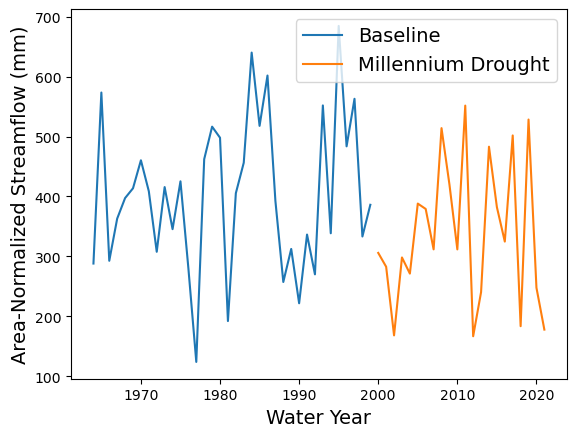

In [13]:
plt.plot(example_pre.WY, example_pre, label='Baseline')
plt.plot(example_post.WY, example_post, label='Millennium Drought')
plt.legend(fontsize=14)
plt.ylabel('Area-Normalized Streamflow (mm)', fontsize=14)
plt.xlabel('Water Year', fontsize=14)
# increase 

p = 0.974


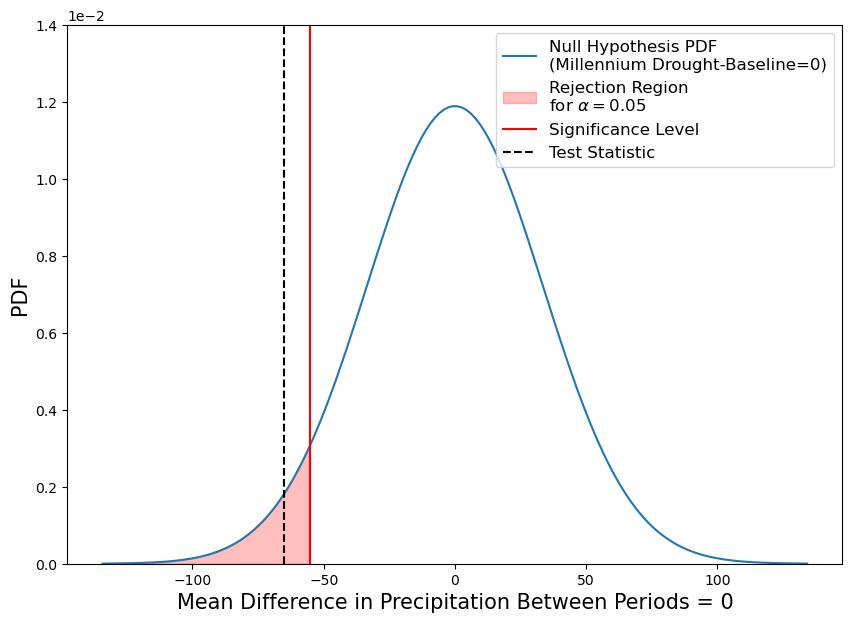

In [14]:
fig, ax = plt.subplots(figsize=(10,7))

# Reference 1 - code adapted from Lab 2-1
# create null pdf
z = np.linspace(-4,4, num=160)*s_pooled
ax.plot(z, 
        stats.norm.pdf(z,delta,s_pooled), 
        label='Null Hypothesis PDF\n(Millennium Drought-Baseline=0)') # 0 and 1 are mu and sigma

# define alpha
alpha = 0.05
# Plot the region that z_test would have to fall in in order for us to reject the null hypothesis
conf = alpha
z_alpha = stats.norm.ppf(conf)
shade_region = np.linspace(np.min(z),z_alpha*s_pooled,10)
ax.fill_between(shade_region,
                stats.norm.pdf(shade_region,delta,s_pooled), 
                color='r', 
                alpha=0.25, 
                label='Rejection Region\n'+r'for $\alpha=0.05$'.format(np.round(conf,2)))
# Plot a line at 95% confidence interval
plt.axvline(z_alpha*s_pooled, 
            color='r', 
            label='Significance Level')
# plt.text(z_alpha*s_pooled, 
#          1.2e-4, 
#          r'Z$_{\alpha}$ = '+str(int(z_alpha)), 
#          fontsize=12, 
#          color='r')
# Plot a line at z_test
plt.axvline(z_test*s_pooled, 
            color='black', 
            linestyle='--', 
            label='Test Statistic')
# plt.text(z_test*s_pooled-30, 
#          0.6e-2, 
#          r'Z$_{test}$ = '+str(int(z_test)), 
#          fontsize=12, 
#          color='k')
# Add labels
ax.set_ylim((0,1.4e-2))
ax.set_xlabel('Mean Difference in Precipitation Between Periods = 0', fontsize=15)
ax.set_ylabel('PDF', fontsize=15)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.legend(fontsize=12, loc='upper right')
# ax.get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ','))) # reference 1
# plt.title('Figure 2.2 - Null Hypothesis: No increse in Sauk River peak mean flows after 1977')
# compute p value
pvalue = 1 - stats.norm.cdf(z_test)
print("p = {}".format(np.round(pvalue,3)))

# Hypothesis testing for change in the flow center of mass between pre- and post-2000 periods

Calculate the daily center of mass for each site for each year

In [15]:
center_of_mass_date = {}
for year in hcdn_daily_q.WY.to_series().unique():
    example = hcdn_daily_q.where(hcdn_daily_q.WY==year,drop=True)['q_mm_day'].cumsum(dim='date')
    com_value = example.max(dim='date')/2
    center_of_mass_date[year] = abs(example - com_value).idxmin(dim='date').dt.dayofyear.to_dataframe()
    
center_of_mass_date_da = xr.Dataset(center_of_mass_date).to_array().squeeze()
center_of_mass_date_da = center_of_mass_date_da.where((center_of_mass_date_da>52) & (center_of_mass_date_da<238))
center_of_mass_date_da = center_of_mass_date_da.rename({'variable':'year'})
center_of_mass_date_da.name = 'flow_com'

In [16]:
# Zero is the mid elevation basins, 1 is the low elevation basins, and 2 are the high elevation basins
basin_elevation_groups = pd.read_csv('../data/geodata/basin_elevation_groups.csv', index_col=1).drop(columns='Unnamed: 0')
basin_elevation_groups.index =  ['0'+str(site) for site in basin_elevation_groups.index.values]
basin_group_da = basin_elevation_groups.to_xarray().rename({'index':'site_no'})

# Merge this data array onto the datasets for use
hcdn_daily_q = hcdn_daily_q.merge(basin_group_da, compat='override')
hcdn_annual_q = hcdn_annual_q.merge(basin_group_da, compat='override')
hcdn_annual_q = hcdn_annual_q.merge(center_of_mass_date_da, compat='override')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.merge(basin_group_da, compat='override')
hcdn_annual_ppt = hcdn_seasonal_ppt.merge(basin_group_da, compat='override')
hcdn_normals_ds = hcdn_normals_ds.merge(basin_group_da, compat='override')

### Separate into low-, mid- and high- elevation sites

In [17]:
high_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 2, drop=True)
mid_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 0, drop=True)
low_elevation_daily_q = hcdn_daily_q.where(hcdn_daily_q.predicted_cluster == 1, drop=True)

high_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 2, drop=True)
mid_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 0, drop=True)
low_elevation_annual_q = hcdn_annual_q.where(hcdn_annual_q.predicted_cluster == 1, drop=True)

high_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 2, drop=True)
mid_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 0, drop=True)
low_elevation_seasonal_ppt = hcdn_seasonal_ppt.where(hcdn_seasonal_ppt.predicted_cluster == 1, drop=True)

high_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 2, drop=True)
mid_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 0, drop=True)
low_elevation_annual_ppt = hcdn_annual_ppt.groupby('year').sum().where(hcdn_annual_ppt.predicted_cluster == 1, drop=True)

# add annual ppt to the annual streamflow dataset
# rename year to WY in the annual ppt dataset
high_elevation_annual_ppt = high_elevation_annual_ppt.rename({'year':'WY'})
mid_elevation_annual_ppt = mid_elevation_annual_ppt.rename({'year':'WY'})
low_elevation_annual_ppt = low_elevation_annual_ppt.rename({'year':'WY'})
high_elevation_annual_q = high_elevation_annual_q.merge(high_elevation_annual_ppt.ppt, compat='override')
mid_elevation_annual_q = mid_elevation_annual_q.merge(mid_elevation_annual_ppt.ppt, compat='override')
low_elevation_annual_q = low_elevation_annual_q.merge(low_elevation_annual_ppt.ppt, compat='override')

In [18]:
com = hcdn_annual_q['flow_com'].mean(dim='year').to_pandas()

In [19]:
site_order = ["09034900",
"09035900",
"09047700",
"09065500",
"09066000",
"09066200",
"09107000",
"09110000",
"09124500",
"09352900",
"09066300",
"09081600",
"09112500",
"09115500",
"09119000",
"09146200",
"09165000",
"09361500",
"09132500",
"09147500",
"09183500",
"09210500",
"09223000",
"09239500",
"09304500",
"09312600"]
com[site_order].to_csv('../data/streamflowdata/flow_com.csv')


In [20]:
conf = 0.05
test_start_year = 1964

1) High Elevation Basins

In [21]:
high_com_ttest_results = pd.DataFrame(index=high_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'value difference'])
for site in high_elevation_annual_q.site_no.values:
    single_site_pre = high_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = high_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        high_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    high_com_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [22]:
high_com_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,value difference
09034900,0.892358,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN,-6.51
09035900,0.668986,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN,-6.32
09047700,0.002336,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.012,Null Hypothesis Rejected,-7.85
09065500,0.872616,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN,-6.63
09066000,0.584393,Probably Gaussian,0.055,Null Hypothesis Accepted,NaN,NaN,-3.95
09066200,0.496821,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN,-7.25
09107000,0.034089,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.115,Null Hypothesis Accepted,-5.72
09110000,0.10967,Probably Gaussian,0.694,Null Hypothesis Accepted,NaN,NaN,1.36
09124500,0.342914,Probably Gaussian,0.0,Null Hypothesis Rejected,NaN,NaN,-8.07
09352900,0.226424,Probably Gaussian,0.0,Null Hypothesis Rejected,NaN,NaN,-9.88


2) Mid Elevation Basins

In [23]:
mid_com_ttest_results = pd.DataFrame(index=mid_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    single_site_pre = mid_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = mid_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        mid_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    mid_com_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [24]:
mid_com_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,value difference
09066300,0.91807,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN,-6.86
09081600,0.778521,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN,-6.13
09112500,0.824163,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN,-6.87
09115500,0.910124,Probably Gaussian,0.034,Null Hypothesis Rejected,NaN,NaN,-9.23
09119000,0.000675,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.122,Null Hypothesis Accepted,-4.06
09146200,0.369699,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN,-8.33
09165000,0.407025,Probably Gaussian,0.0,Null Hypothesis Rejected,NaN,NaN,-9.83
09361500,0.541101,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN,-7.45


3) Low Elevation Basins

In [25]:
low_com_ttest_results = pd.DataFrame(index=low_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'value difference',])
for site in low_elevation_annual_q.site_no.values:
    single_site_pre = low_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = low_elevation_annual_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        low_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

    low_com_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)


### Flow Center of Mass Change Plots

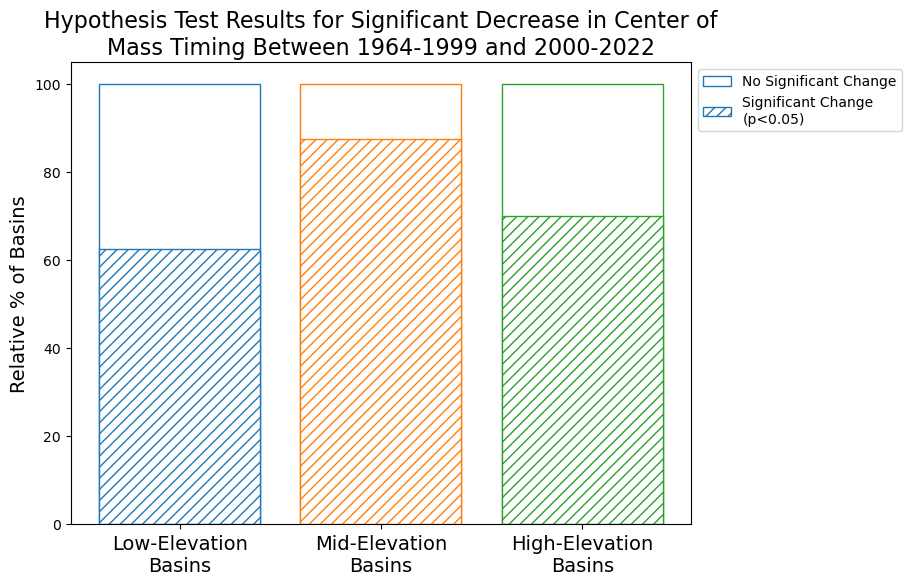

In [26]:

# create a dataframe with the results
low_rejected = len(low_com_ttest_results[(low_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_com_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_com_ttest_results[(mid_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_com_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_com_ttest_results[(high_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_com_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/8), 100*(mid_rejected/8), 100*(high_rejected/10)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Center of\nMass Timing Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

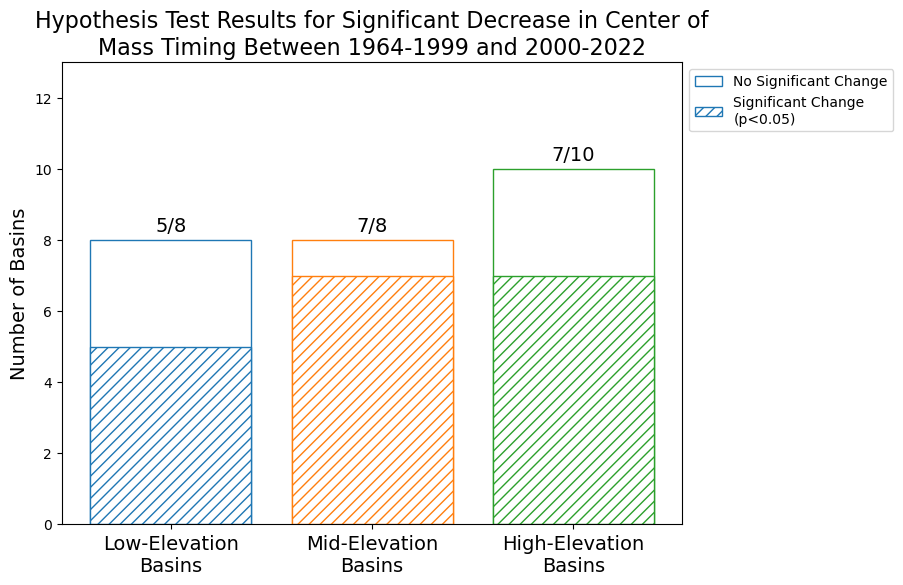

In [27]:
# create a dataframe with the results
low_rejected = len(low_com_ttest_results[(low_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_com_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_com_ttest_results[(mid_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_com_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_com_ttest_results[(high_com_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_com_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[8, 8, 10], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[(low_rejected), (mid_rejected), (high_rejected)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Center of\nMass Timing Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=8.25, s=f'{low_rejected}/8', fontsize=14, ha='center')
ax.text(x=1, y=8.25, s=f'{mid_rejected}/8', fontsize=14, ha='center')
ax.text(x=2, y=10.25, s=f'{high_rejected}/10', fontsize=14, ha='center')
ax.set_ylim(0,13)

# Hypothesis testing for change in annual mean flow between pre- and post-2000 periods

1) High Elevation Basins

In [28]:
high_meanq_ttest_results = pd.DataFrame(index=high_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference [mm]'])
for site in high_elevation_annual_q.site_no.values:
    single_site_pre = high_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[1964:1999]
    single_site_post = high_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > 100:
        high_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
       
    else:
        high_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
     # calculate the percent change between the two periods
    high_meanq_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    high_meanq_ttest_results.loc[site,'value difference [mm]'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [29]:
high_meanq_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference [mm]
09034900,0.211445,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.095,Null Hypothesis Accepted,-10.2,-70.8
09035900,0.062464,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.51,Null Hypothesis Accepted,-2.3,-9.4
09047700,0.013684,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.265,Null Hypothesis Accepted,-10.1,-24.8
09065500,0.179239,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.084,Null Hypothesis Accepted,-11.1,-80.7
09066000,0.240884,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.133,Null Hypothesis Accepted,-9.7,-46.3
09066200,0.299846,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.062,Null Hypothesis Accepted,-13.5,-90.9
09107000,0.088826,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.08,Null Hypothesis Accepted,-15.2,-47.9
09110000,0.328975,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.004,Null Hypothesis Rejected,-19.0,-45.8
09124500,0.804693,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.089,Null Hypothesis Accepted,-10.7,-25.4
09352900,0.242739,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.026,Null Hypothesis Rejected,-15.6,-112.2


2) Mid Elevation Basins

In [30]:
mid_meanq_ttest_results = pd.DataFrame(index=mid_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference [mm]'])
for site in mid_elevation_annual_q.site_no.values:
    single_site_pre = mid_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = mid_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > 100:
        mid_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    mid_meanq_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    mid_meanq_ttest_results.loc[site,'value difference [mm]'] = np.round((single_site_post.mean()-single_site_pre.mean()),1)

In [31]:
mid_meanq_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference [mm]
09066300,0.059042,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.046,Null Hypothesis Rejected,-18.2,-61.5
09081600,0.454766,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.046,Null Hypothesis Rejected,-12.8,-80.8
09112500,0.996541,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.023,Null Hypothesis Rejected,-16.4,-66.1
09115500,0.910503,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.092,Null Hypothesis Accepted,-12.2,-18.3
09119000,0.003218,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.014,Null Hypothesis Rejected,-22.7,-13.4
09146200,0.964195,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.047,Null Hypothesis Rejected,-11.9,-47.3
09165000,0.040168,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.014,Null Hypothesis Rejected,-20.6,-93.3
09361500,0.06976,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.016,Null Hypothesis Rejected,-19.5,-78.8


3) Low Elevation Basins

In [32]:
low_meanq_ttest_results = pd.DataFrame(index=low_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference [mm]'])
for site in low_elevation_annual_q.site_no.values:
    single_site_pre = low_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = low_elevation_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_meanq_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > 100:
        low_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_meanq_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_meanq_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_meanq_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_meanq_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_meanq_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    low_meanq_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    low_meanq_ttest_results.loc[site,'value difference [mm]'] = np.round((single_site_post.mean()-single_site_pre.mean()),1)

In [33]:
low_meanq_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference [mm]
09132500,0.214716,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.02,Null Hypothesis Rejected,-22.3,-72.0
09147500,0.17333,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.035,Null Hypothesis Rejected,-19.2,-39.6
09183500,0.754493,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.003,Null Hypothesis Rejected,-29.2,-47.3
09210500,0.25406,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.078,Null Hypothesis Accepted,-13.7,-23.4
09223000,0.857539,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.01,Null Hypothesis Rejected,-24.5,-70.1
09239500,0.875212,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.082,Null Hypothesis Accepted,-10.8,-30.7
09304500,0.783112,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.012,Null Hypothesis Rejected,-15.2,-43.9
09312600,0.399327,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.001,Null Hypothesis Rejected,-40.6,-53.7


4. Upper Colorado River Basin

In [125]:
ucrb_meanq_ttest_results = pd.DataFrame(index=['UCRB'], columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent difference',
                                                                                    'value difference'])

single_site_pre = ucrb_naturalized_streamflow['q_mm_day'].loc[test_start_year:1999]
single_site_post = ucrb_naturalized_streamflow['q_mm_day'].loc[2000:2022]
# Example of the Shapiro-Wilk Normality Test
stat, p = stats.shapiro(single_site_pre)
ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke p'] = p

if p > conf:
    ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian'
    
    z_alpha = stats.norm.ppf(conf)
    # print("z_alpha = {}".format(z_alpha)) 

    s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                    (single_site_post.std(ddof=1)**2)/len(single_site_post))
    # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

    # null hypothesis: no change in sample means
    delta = 0*single_site_pre.mean()
    # compute test statistic
    z_test = ((single_site_post.mean()-single_site_pre.mean())-
            delta)/s_pooled
    # print("z-score = {}".format(np.round(z_test,2))) 
    # compute p value
    pvalue = stats.norm.cdf(z_test)
    ucrb_meanq_ttest_results.loc['UCRB','t-test p'] = np.round(pvalue,3)
    if pvalue < conf:
        ucrb_meanq_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_meanq_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Accepted'
else:
    ucrb_meanq_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
    stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    ucrb_meanq_ttest_results.loc['UCRB','mannwhitney p'] = np.round(p_value,3)
    if p_value < conf:
        ucrb_meanq_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_meanq_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Accepted'
ucrb_meanq_ttest_results.loc['UCRB','percent difference'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
ucrb_meanq_ttest_results.loc['UCRB','value difference'] = np.round(single_site_post.mean()-single_site_pre.mean())

### Annual Mean Flow Change Plots

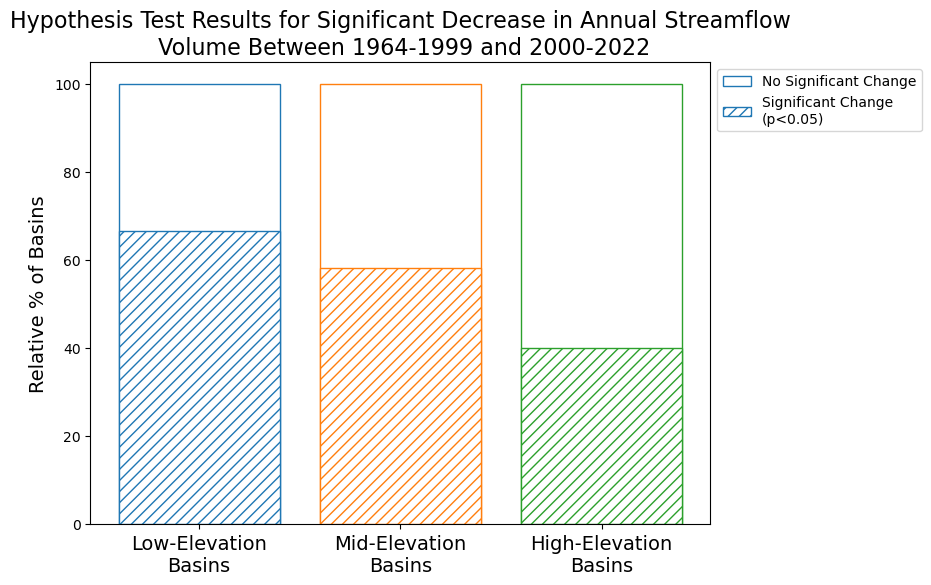

In [35]:

# create a dataframe with the results
low_rejected = len(low_meanq_ttest_results[(low_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_meanq_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_meanq_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_meanq_ttest_results[(high_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_meanq_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/9), 100*(mid_rejected/12), 100*(high_rejected/5)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Annual Streamflow\n Volume Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

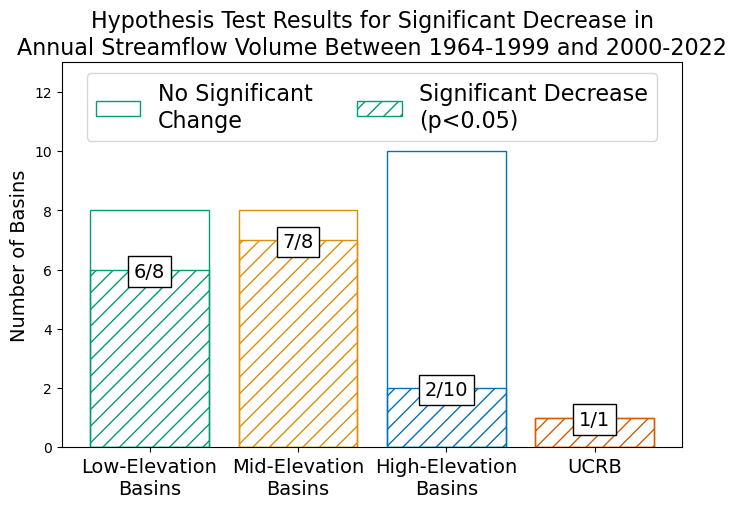

In [132]:
# create a dataframe with the results
low_rejected = len(low_meanq_ttest_results[(low_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_meanq_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_meanq_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_meanq_ttest_results[(high_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_meanq_ttest_results['mannwhitney p']<=0.05)])
# calculate the same values but with 0.10 as the threshold
low_rejected_10 = len(low_meanq_ttest_results[(low_meanq_ttest_results['t-test p']<=0.10) |
                                               (low_meanq_ttest_results['mannwhitney p']<=0.10)])                                         
mid_rejected_10 = len(mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test p']<=0.10) |
                                                   (mid_meanq_ttest_results['mannwhitney p']<=0.10)])    
high_rejected_10 = len(high_meanq_ttest_results[(high_meanq_ttest_results['t-test p']<=0.10) |
                                                         (high_meanq_ttest_results['mannwhitney p']<=0.10)])

ucrb_rejected = len(ucrb_meanq_ttest_results[(ucrb_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (ucrb_meanq_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[8, 8, 10, 1], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['white','white','white', 'white'])
# ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'],
#        height=[(low_rejected_10), (mid_rejected_10), (high_rejected_10),1],
#        ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
#            (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
#            (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
#            (0.8352941176470589, 0.3686274509803922, 0.0)],
#        color=['white','white','white','white'],
#        hatch='\\\\')

ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['none','none','none', 'none'], 
       hatch='//')
# add a legend with the hatch pattern
ax.legend(['No Significant\nChange','Significant Decrease\n(p<0.05)'], ncols=3, loc='upper center', fontsize=16)
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in\nAnnual Streamflow Volume Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=low_rejected-0.25, s=f'{low_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=1, y=mid_rejected-0.25, s=f'{mid_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=2, y=high_rejected-0.25, s=f'{high_rejected}/10', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=3, y=ucrb_rejected-0.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.set_ylim(0,13)

# Hypothesis testing for change in the distribution of seasonal precipitation in pre- and post-2000 periods

1) High Elevation Basins

Text(0.5, 1.0, 'Summer')

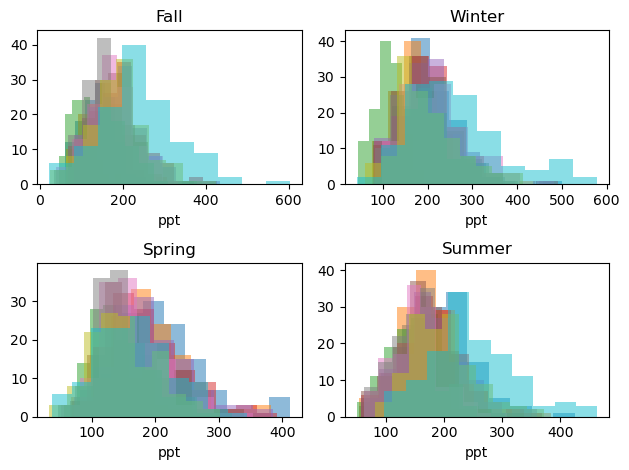

In [37]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in high_elevation_seasonal_ppt.site_no:
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==10,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==1,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==4,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==7,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [38]:
high_fallp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_fallp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_fallp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_fallp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    high_fallp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    high_fallp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [39]:
high_fallp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09034900,0.041778,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.748,Null Hypothesis Accepted,3.49,5.38
09035900,0.009999,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.748,Null Hypothesis Accepted,4.19,7.15
09047700,0.001885,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.716,Null Hypothesis Accepted,2.03,2.12
09065500,0.004168,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.456,Null Hypothesis Accepted,-0.88,-1.9
09066000,0.003024,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.351,Null Hypothesis Accepted,-1.84,-3.97
09066200,0.005768,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.637,Null Hypothesis Accepted,1.62,3.11
09107000,0.047694,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.123,Null Hypothesis Accepted,-9.19,-18.47
09110000,0.029009,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.273,Null Hypothesis Accepted,-6.61,-11.75
09124500,0.921158,Probably Gaussian,0.06,Null Hypothesis Accepted,NaN,NaN,-12.97,-27.69
09352900,0.421637,Probably Gaussian,0.101,Null Hypothesis Accepted,NaN,NaN,-12.5,-33.56


In [40]:
high_winterp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
                                                                        
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    high_winterp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    high_winterp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [41]:
high_winterp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09034900,0.14438,Probably Gaussian,0.699,Null Hypothesis Accepted,NaN,NaN,3.63,7.47
09035900,0.135202,Probably Gaussian,0.797,Null Hypothesis Accepted,NaN,NaN,5.61,10.04
09047700,0.058654,Probably Gaussian,0.962,Null Hypothesis Accepted,NaN,NaN,14.79,15.84
09065500,0.434048,Probably Gaussian,0.514,Null Hypothesis Accepted,NaN,NaN,0.23,0.47
09066000,0.390388,Probably Gaussian,0.593,Null Hypothesis Accepted,NaN,NaN,1.55,3.18
09066200,0.233995,Probably Gaussian,0.665,Null Hypothesis Accepted,NaN,NaN,2.77,5.43
09107000,0.160815,Probably Gaussian,0.056,Null Hypothesis Accepted,NaN,NaN,-11.88,-26.82
09110000,0.043231,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.06,Null Hypothesis Accepted,-9.75,-19.79
09124500,0.670906,Probably Gaussian,0.274,Null Hypothesis Accepted,NaN,NaN,-5.29,-10.23
09352900,0.567766,Probably Gaussian,0.24,Null Hypothesis Accepted,NaN,NaN,-7.65,-19.9


In [42]:
high_springp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    high_springp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    high_springp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [43]:
high_springp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09034900,0.006607,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.174,Null Hypothesis Accepted,-12.0,-26.5
09035900,0.020741,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.178,Null Hypothesis Accepted,-11.2,-22.8
09047700,0.001946,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.557,Null Hypothesis Accepted,-4.5,-6.4
09065500,0.002694,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.475,Null Hypothesis Accepted,-6.9,-13.6
09066000,0.003752,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.4,Null Hypothesis Accepted,-8.8,-18.0
09066200,0.000659,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.711,Null Hypothesis Accepted,-1.2,-2.1
09107000,0.000346,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.066,Null Hypothesis Accepted,-16.2,-28.3
09110000,0.00044,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.021,Null Hypothesis Rejected,-17.0,-27.1
09124500,0.221001,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN,-21.3,-34.1
09352900,0.704062,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN,-26.2,-47.8


In [44]:
high_summerp_ttest_results = pd.DataFrame(index=high_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'
                                                                                    ])
for site in high_elevation_annual_q.site_no.values:
    minyear = high_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (high_elevation_seasonal_ppt.where(high_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        high_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            high_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        high_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    high_summerp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    high_summerp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)
    

In [45]:
high_summerp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09034900,0.209093,Probably Gaussian,0.524,Null Hypothesis Accepted,NaN,NaN,-0.51,-1.0
09035900,0.13881,Probably Gaussian,0.541,Null Hypothesis Accepted,NaN,NaN,-0.78,-1.34
09047700,0.447565,Probably Gaussian,0.362,Null Hypothesis Accepted,NaN,NaN,2.81,4.18
09065500,0.737943,Probably Gaussian,0.485,Null Hypothesis Accepted,NaN,NaN,0.3,0.54
09066000,0.600307,Probably Gaussian,0.4,Null Hypothesis Accepted,NaN,NaN,2.08,3.8
09066200,0.558447,Probably Gaussian,0.476,Null Hypothesis Accepted,NaN,NaN,0.44,0.72
09107000,0.712296,Probably Gaussian,0.543,Null Hypothesis Accepted,NaN,NaN,-0.79,-1.25
09110000,0.765622,Probably Gaussian,0.433,Null Hypothesis Accepted,NaN,NaN,1.21,1.87
09124500,0.449996,Probably Gaussian,0.776,Null Hypothesis Accepted,NaN,NaN,-5.68,-11.47
09352900,0.2127,Probably Gaussian,0.947,Null Hypothesis Accepted,NaN,NaN,-12.99,-34.24


2) Mid Elevation Basins

Text(0.5, 1.0, 'Summer')

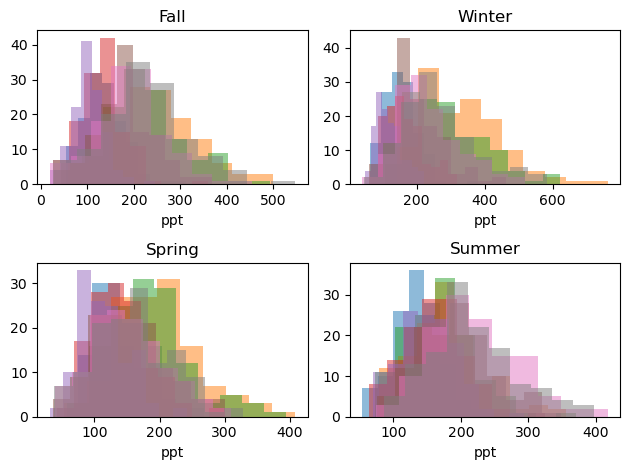

In [46]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in mid_elevation_seasonal_ppt.site_no:
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==10,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==1,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==4,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==7,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [47]:
mid_fallp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_fallp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_fallp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_fallp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    mid_fallp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    mid_fallp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [48]:
mid_fallp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09066300,0.008756,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.582,Null Hypothesis Accepted,1.01,1.54
09081600,0.88399,Probably Gaussian,0.058,Null Hypothesis Accepted,NaN,NaN,-12.22,-36.09
09112500,0.289883,Probably Gaussian,0.026,Null Hypothesis Rejected,NaN,NaN,-14.85,-39.51
09115500,0.003514,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.204,Null Hypothesis Accepted,-8.65,-13.11
09119000,0.256384,Probably Gaussian,0.092,Null Hypothesis Accepted,NaN,NaN,-10.01,-11.62
09146200,0.812212,Probably Gaussian,0.044,Null Hypothesis Rejected,NaN,NaN,-13.16,-27.37
09165000,0.840939,Probably Gaussian,0.08,Null Hypothesis Accepted,NaN,NaN,-13.08,-28.85
09361500,0.611295,Probably Gaussian,0.066,Null Hypothesis Accepted,NaN,NaN,-14.14,-36.51


In [49]:
mid_winterp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    mid_winterp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    mid_winterp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [50]:
mid_winterp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09066300,0.212436,Probably Gaussian,0.845,Null Hypothesis Accepted,NaN,NaN,7.42,11.13
09081600,0.014797,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.012,Null Hypothesis Rejected,-15.62,-52.59
09112500,0.043536,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.014,Null Hypothesis Rejected,-15.78,-47.73
09115500,0.144279,Probably Gaussian,0.143,Null Hypothesis Accepted,NaN,NaN,-9.59,-16.51
09119000,0.29379,Probably Gaussian,0.222,Null Hypothesis Accepted,NaN,NaN,-6.91,-8.36
09146200,0.979016,Probably Gaussian,0.366,Null Hypothesis Accepted,NaN,NaN,-2.82,-5.45
09165000,0.451413,Probably Gaussian,0.183,Null Hypothesis Accepted,NaN,NaN,-9.38,-21.82
09361500,0.627421,Probably Gaussian,0.21,Null Hypothesis Accepted,NaN,NaN,-8.33,-21.79


In [51]:
mid_springp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)]
    single_site_post = mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        mid_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    mid_springp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    mid_springp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [52]:
mid_springp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09066300,0.000207,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.727,Null Hypothesis Accepted,0.2,0.3
09081600,0.039817,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.043,Null Hypothesis Rejected,-16.0,-34.2
09112500,0.002003,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.014,Null Hypothesis Rejected,-19.9,-40.2
09115500,0.030445,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.007,Null Hypothesis Rejected,-18.1,-26.9
09119000,0.030682,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.003,Null Hypothesis Rejected,-20.9,-25.1
09146200,0.37868,Probably Gaussian,0.007,Null Hypothesis Rejected,NaN,NaN,-21.1,-34.9
09165000,0.286937,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN,-24.9,-40.6
09361500,0.202946,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN,-23.6,-40.5


In [53]:
mid_summerp_ttest_results = pd.DataFrame(index=mid_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    minyear = mid_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (mid_elevation_seasonal_ppt.where(mid_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = 1-stats.norm.cdf(z_test)
        mid_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue > 1-conf:
            mid_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        mid_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    mid_summerp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    mid_summerp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [54]:
mid_summerp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09066300,0.053573,Probably Gaussian,0.267,Null Hypothesis Accepted,NaN,NaN,4.7,6.46
09081600,0.126802,Probably Gaussian,0.274,Null Hypothesis Accepted,NaN,NaN,5.11,9.33
09112500,0.806824,Probably Gaussian,0.398,Null Hypothesis Accepted,NaN,NaN,2.01,3.43
09115500,0.25064,Probably Gaussian,0.782,Null Hypothesis Accepted,NaN,NaN,-5.73,-9.58
09119000,0.309295,Probably Gaussian,0.832,Null Hypothesis Accepted,NaN,NaN,-6.57,-10.21
09146200,0.597809,Probably Gaussian,0.735,Null Hypothesis Accepted,NaN,NaN,-4.65,-9.18
09165000,0.35037,Probably Gaussian,0.879,Null Hypothesis Accepted,NaN,NaN,-9.0,-20.33
09361500,0.28901,Probably Gaussian,0.918,Null Hypothesis Accepted,NaN,NaN,-10.69,-24.46


3) Low Elevation Basins

Text(0.5, 1.0, 'Summer')

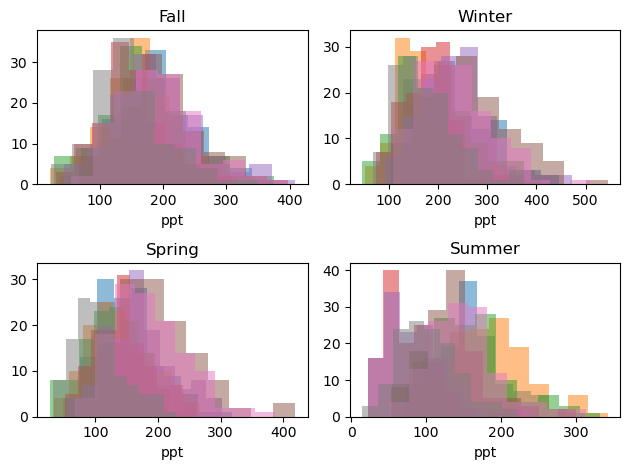

In [55]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()
for site in low_elevation_seasonal_ppt.site_no:
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==10,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==1,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==4,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
    low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==7,drop=True).sel(site_no=site)['ppt'].plot.hist(ax=axs[3], alpha=0.5)
axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [56]:
low_fallp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==10, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_fallp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_fallp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_fallp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_fallp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_fallp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_fallp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    low_fallp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    low_fallp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [57]:
low_fallp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09132500,0.644028,Probably Gaussian,0.102,Null Hypothesis Accepted,NaN,NaN,-9.87,-21.02
09147500,0.799912,Probably Gaussian,0.054,Null Hypothesis Accepted,NaN,NaN,-12.59,-22.72
09183500,0.919712,Probably Gaussian,0.129,Null Hypothesis Accepted,NaN,NaN,-12.03,-23.06
09210500,0.502821,Probably Gaussian,0.147,Null Hypothesis Accepted,NaN,NaN,-8.55,-14.84
09223000,0.633915,Probably Gaussian,0.141,Null Hypothesis Accepted,NaN,NaN,-8.88,-19.47
09239500,0.346597,Probably Gaussian,0.091,Null Hypothesis Accepted,NaN,NaN,-8.4,-18.68
09304500,0.111587,Probably Gaussian,0.011,Null Hypothesis Rejected,NaN,NaN,-15.27,-34.38
09312600,0.187166,Probably Gaussian,0.431,Null Hypothesis Accepted,NaN,NaN,-1.8,-2.91


In [58]:
low_winterp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==1, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_winterp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_winterp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_winterp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_winterp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_winterp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_winterp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    low_winterp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    low_winterp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [59]:
low_winterp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09132500,0.061069,Probably Gaussian,0.086,Null Hypothesis Accepted,NaN,NaN,-10.45,-23.57
09147500,0.975688,Probably Gaussian,0.34,Null Hypothesis Accepted,NaN,NaN,-3.42,-5.78
09183500,0.286455,Probably Gaussian,0.075,Null Hypothesis Accepted,NaN,NaN,-15.06,-28.98
09210500,0.756451,Probably Gaussian,0.181,Null Hypothesis Accepted,NaN,NaN,-7.66,-14.65
09223000,0.856316,Probably Gaussian,0.169,Null Hypothesis Accepted,NaN,NaN,-7.86,-19.47
09239500,0.919609,Probably Gaussian,0.046,Null Hypothesis Rejected,NaN,NaN,-10.25,-26.91
09304500,0.493703,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN,-17.94,-43.9
09312600,0.0204,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.158,Null Hypothesis Accepted,-8.32,-14.68


In [60]:
low_springp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==4, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < 0.1:
            low_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_springp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < 0.1:
            low_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    low_springp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    low_springp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

In [61]:
low_winterp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09132500,0.061069,Probably Gaussian,0.086,Null Hypothesis Accepted,NaN,NaN,-10.45,-23.57
09147500,0.975688,Probably Gaussian,0.34,Null Hypothesis Accepted,NaN,NaN,-3.42,-5.78
09183500,0.286455,Probably Gaussian,0.075,Null Hypothesis Accepted,NaN,NaN,-15.06,-28.98
09210500,0.756451,Probably Gaussian,0.181,Null Hypothesis Accepted,NaN,NaN,-7.66,-14.65
09223000,0.856316,Probably Gaussian,0.169,Null Hypothesis Accepted,NaN,NaN,-7.86,-19.47
09239500,0.919609,Probably Gaussian,0.046,Null Hypothesis Rejected,NaN,NaN,-10.25,-26.91
09304500,0.493703,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN,-17.94,-43.9
09312600,0.0204,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.158,Null Hypothesis Accepted,-8.32,-14.68


In [62]:
low_summerp_ttest_results = pd.DataFrame(index=low_elevation_seasonal_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
                                                                          
for site in low_elevation_annual_q.site_no.values:
    minyear = low_elevation_annual_q['00060_Mean'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(test_start_year,10,1):dt.date(1999,9,30)])
    single_site_post = (low_elevation_seasonal_ppt.where(low_elevation_seasonal_ppt.month.dt.month==7, drop=True).sel(site_no=site)['ppt'].to_pandas().dropna().loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_summerp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_summerp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_summerp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_summerp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_summerp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_summerp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    low_summerp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
    low_summerp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [63]:
high_fallp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09034900,0.041778,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.748,Null Hypothesis Accepted,3.49,5.38
09035900,0.009999,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.748,Null Hypothesis Accepted,4.19,7.15
09047700,0.001885,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.716,Null Hypothesis Accepted,2.03,2.12
09065500,0.004168,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.456,Null Hypothesis Accepted,-0.88,-1.9
09066000,0.003024,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.351,Null Hypothesis Accepted,-1.84,-3.97
09066200,0.005768,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.637,Null Hypothesis Accepted,1.62,3.11
09107000,0.047694,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.123,Null Hypothesis Accepted,-9.19,-18.47
09110000,0.029009,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.273,Null Hypothesis Accepted,-6.61,-11.75
09124500,0.921158,Probably Gaussian,0.06,Null Hypothesis Accepted,NaN,NaN,-12.97,-27.69
09352900,0.421637,Probably Gaussian,0.101,Null Hypothesis Accepted,NaN,NaN,-12.5,-33.56


4. Upper Colorado River Basin

In [64]:
# Seasonal Precipitation Plot
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.month.dt.days_in_month

    # Calculate the weighted average
    return (ds).resample(month='QS-OCT').mean() * 3

In [65]:
ucrb_ppt_seasonal_mean = season_mean(p_mean.drop('WY'))
ucrb_ppt_seasonal_mean['WY'] = ucrb_ppt_seasonal_mean.month.dt.year.where(ucrb_ppt_seasonal_mean.month.dt.month<10, ucrb_ppt_seasonal_mean.month.dt.year+1)

Text(0.5, 1.0, 'Summer')

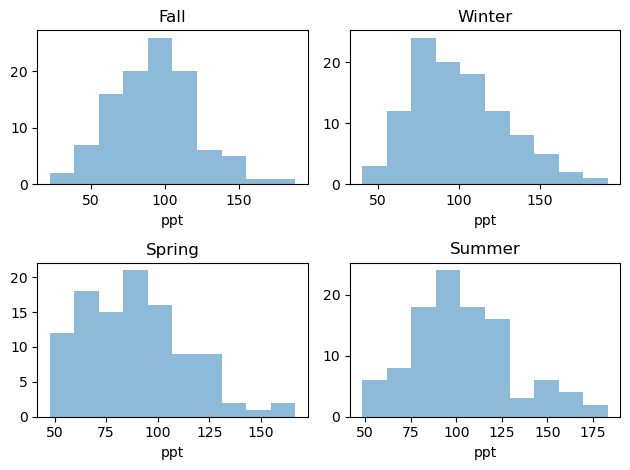

In [66]:
fig, axs = plt.subplots(2,2, tight_layout=True)
axs = axs.ravel()

ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==10),drop=True)['ppt'].plot.hist(ax=axs[0], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==1),drop=True)['ppt'].plot.hist(ax=axs[1], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==4),drop=True)['ppt'].plot.hist(ax=axs[2], alpha=0.5)
ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.WY<2000)&(ucrb_ppt_seasonal_mean.month.dt.month==7),drop=True)['ppt'].plot.hist(ax=axs[3], alpha=0.5)

axs[0].set_title('Fall')
axs[1].set_title('Winter')
axs[2].set_title('Spring')
axs[3].set_title('Summer')

In [67]:
season_list = ['fall','winter','spring','summer']
ucrb_seasonalppt_ttest_results = pd.DataFrame(index=season_list, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change (spring)',
                                                                                    'value difference (spring)'])
seasons = [ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==10),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==1),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==4),drop=True)['ppt'].to_pandas(),
            ucrb_ppt_seasonal_mean.where((ucrb_ppt_seasonal_mean.month.dt.month==7),drop=True)['ppt'].to_pandas()]
for i,ds_seas in enumerate(seasons):
    single_site_pre = (ds_seas.loc[dt.date(test_start_year,9,30):dt.date(1999,9,30)])
    single_site_post = (ds_seas.loc[dt.date(1999,10,1):])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke p'] = p

    if p > 100:
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke Result'] = 'Probably Gaussian'
        if season_list[i] =='summer':
            # run the test for 1-conf
            z_alpha = stats.norm.ppf(conf)
        else:
            z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        if season_list[i] =='summer':
            # run the test for 1-conf
            pvalue = 1-stats.norm.cdf(z_test)
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test p'] = np.round(pvalue,3)
            if pvalue > 1-conf:
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Rejected'
            else: 
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Accepted'
        else:
            pvalue = stats.norm.cdf(z_test)
        
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test p'] = np.round(pvalue,3)
            if pvalue < conf:
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Rejected'
            else: 
                ucrb_seasonalppt_ttest_results.loc[season_list[i],'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        if season_list[i] =='summer':
            stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        else:
            stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            ucrb_seasonalppt_ttest_results.loc[season_list[i],'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # calculate the percent change between the two periods
    ucrb_seasonalppt_ttest_results.loc[season_list[i],'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    ucrb_seasonalppt_ttest_results.loc[season_list[i],'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)

### Winter Precipitation Shift Results

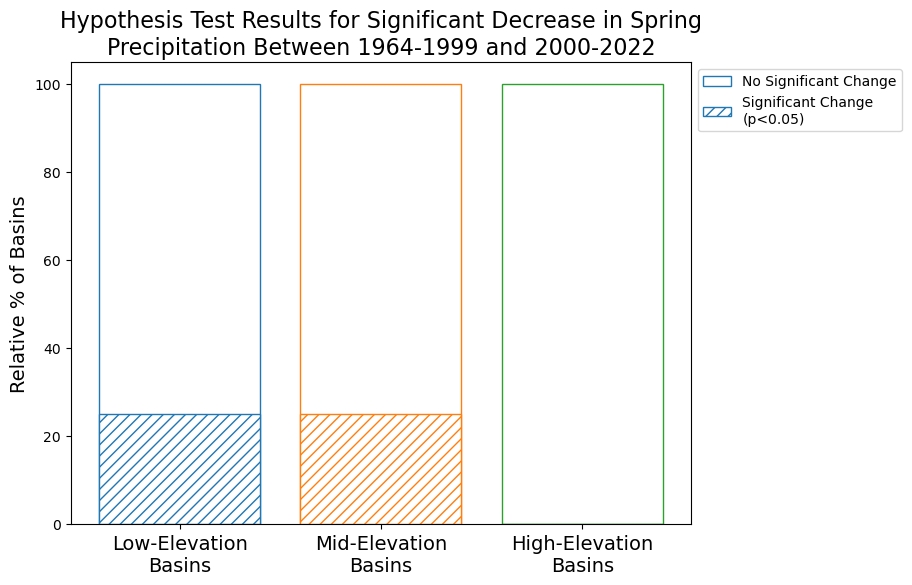

In [68]:

# create a dataframe with the results
low_rejected = len(low_winterp_ttest_results[(low_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_winterp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_winterp_ttest_results[(mid_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_winterp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_winterp_ttest_results[(high_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_winterp_ttest_results['mannwhitney p']<=0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/8), 100*(mid_rejected/8), 100*(high_rejected/10)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

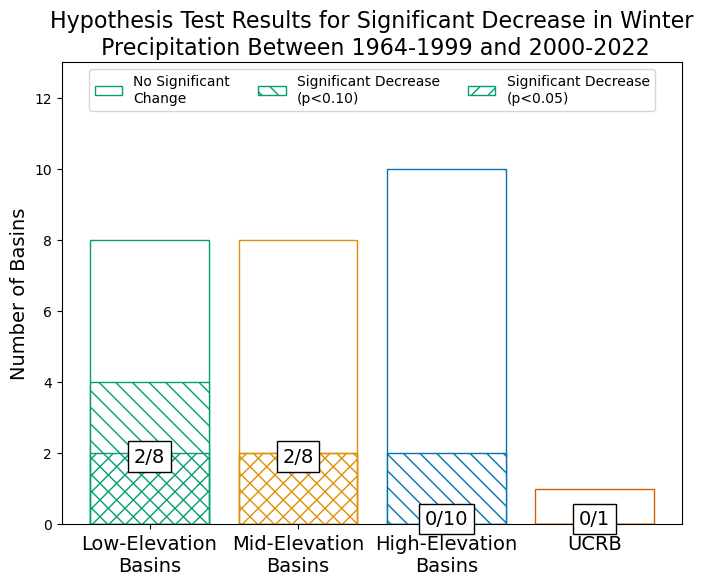

In [69]:
# create a dataframe with the results
low_rejected = len(low_winterp_ttest_results[(low_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_winterp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_winterp_ttest_results[(mid_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_winterp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_winterp_ttest_results[(high_winterp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_winterp_ttest_results['mannwhitney p']<=0.05)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='winter']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.05)])
# calculate the same values but with 0.10 as the threshold
low_rejected_10 = len(low_winterp_ttest_results[(low_winterp_ttest_results['t-test p']<=0.10) |
                                               (low_winterp_ttest_results['mannwhitney p']<=0.10)])                                         
mid_rejected_10 = len(mid_winterp_ttest_results[(mid_winterp_ttest_results['t-test p']<=0.10) |
                                                   (mid_winterp_ttest_results['mannwhitney p']<=0.10)])    
high_rejected_10 = len(high_winterp_ttest_results[(high_winterp_ttest_results['t-test p']<=0.10) |
                                                         (high_winterp_ttest_results['mannwhitney p']<=0.10)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[8, 8, 10, 1], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'],
       height=[(low_rejected_10), (mid_rejected_10), (high_rejected_10),0],
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
           (0.8352941176470589, 0.3686274509803922, 0.0)],
       color=['white','white','white','white'],
       hatch='\\\\')

ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['none','none','none', 'none'], 
       hatch='//')
# add a legend with the hatch pattern
ax.legend(['No Significant\nChange', 'Significant Decrease\n(p<0.10)','Significant Decrease\n(p<0.05)'], ncols=3, loc='upper center', fontsize=10)
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Winter\n Precipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=low_rejected-0.25, s=f'{low_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=1, y=mid_rejected-0.25, s=f'{mid_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=2, y=high_rejected, s=f'{high_rejected}/10', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=3, y=ucrb_rejected, s=f'{ucrb_rejected}/1', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.set_ylim(0,13)

### Spring Precipitation Shift Results

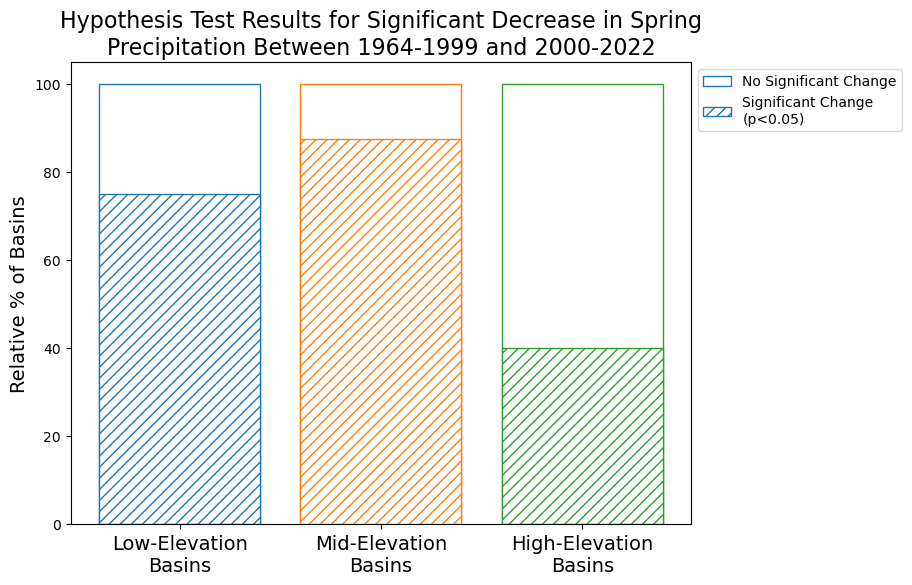

In [70]:

# create a dataframe with the results
low_rejected = len(low_springp_ttest_results[(low_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_springp_ttest_results['mannwhitney p']<=0.10)])
mid_rejected = len(mid_springp_ttest_results[(mid_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_springp_ttest_results['mannwhitney p']<=0.10)])
high_rejected = len(high_springp_ttest_results[(high_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_springp_ttest_results['mannwhitney p']<=0.10)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/8), 100*(mid_rejected/8), 100*(high_rejected/10)], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

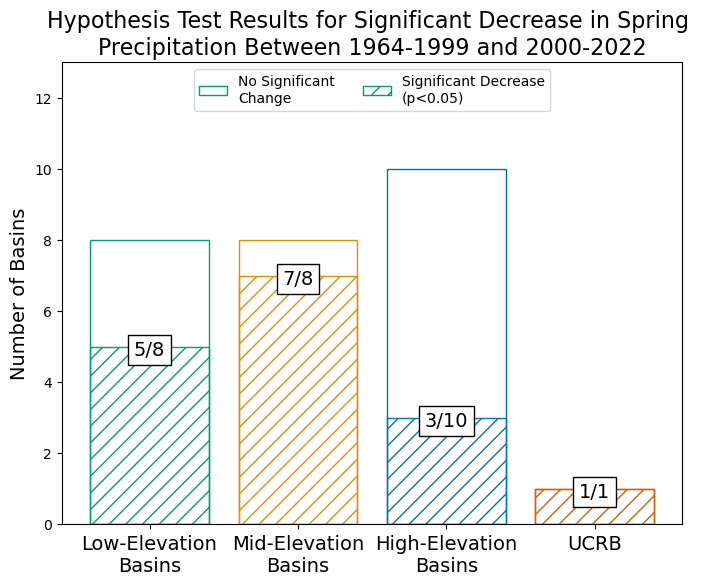

In [71]:
# create a dataframe with the results
low_rejected = len(low_springp_ttest_results[(low_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_springp_ttest_results['mannwhitney p']<=0.05)])
mid_rejected = len(mid_springp_ttest_results[(mid_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_springp_ttest_results['mannwhitney p']<=0.05)])
high_rejected = len(high_springp_ttest_results[(high_springp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_springp_ttest_results['mannwhitney p']<=0.05)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='spring']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.05)])
# # calculate the same values but with 0.10 as the threshold
# low_rejected_10 = len(low_springp_ttest_results[(low_springp_ttest_results['t-test p']<=0.10) |
#                                                (low_springp_ttest_results['mannwhitney p']<=0.10)])                                         
# mid_rejected_10 = len(mid_springp_ttest_results[(mid_springp_ttest_results['t-test p']<=0.10) |
#                                                    (mid_springp_ttest_results['mannwhitney p']<=0.10)])    
# high_rejected_10 = len(high_springp_ttest_results[(high_springp_ttest_results['t-test p']<=0.10) |
#                                                          (high_springp_ttest_results['mannwhitney p']<=0.10)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[8, 8, 10, 1], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['white','white','white', 'white'])
# ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'],
#        height=[(low_rejected_10), (mid_rejected_10), (high_rejected_10),1],
#        ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
#            (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
#            (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
#            (0.8352941176470589, 0.3686274509803922, 0.0)],
#        color=['white','white','white','white'],
#        hatch='\\\\')

ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['none','none','none', 'none'], 
       hatch='//')
# add a legend with the hatch pattern
ax.legend(['No Significant\nChange', 'Significant Decrease\n(p<0.05)'], ncols=3, loc='upper center', fontsize=10)
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Spring \nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=low_rejected-0.25, s=f'{low_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=1, y=mid_rejected-0.25, s=f'{mid_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=2, y=high_rejected-0.25, s=f'{high_rejected}/10', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=3, y=ucrb_rejected-0.25, s=f'{ucrb_rejected}/1', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.set_ylim(0,13)

### Summer Precipitation Shift Results

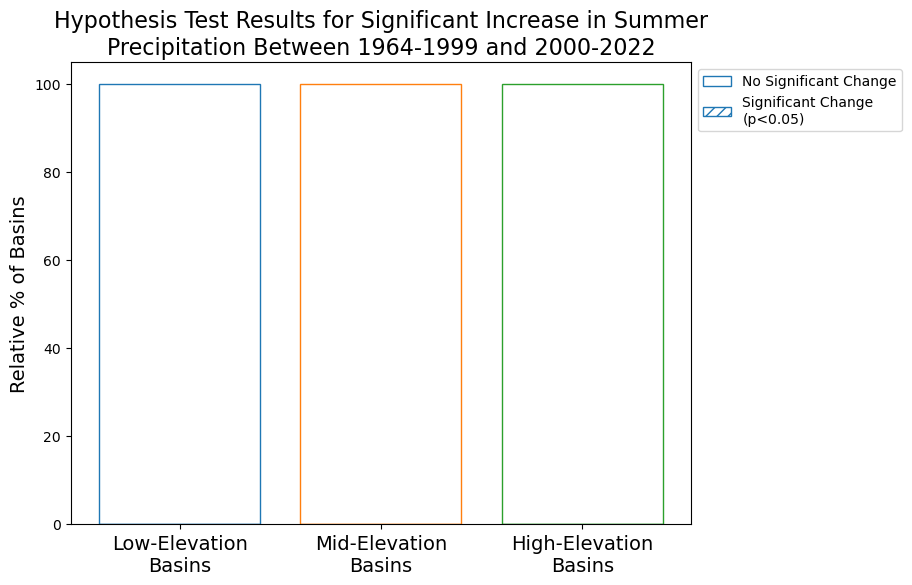

In [72]:

# create a dataframe with the results
low_rejected = len(low_summerp_ttest_results[(low_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_summerp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_summerp_ttest_results[(mid_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_summerp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_summerp_ttest_results[(high_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_summerp_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/len(low_summerp_ttest_results)), 100*(mid_rejected/len(mid_summerp_ttest_results)), 100*(high_rejected/len(high_summerp_ttest_results))], 
       ec=['#1f77b4','#ff7f0e','#2ca02c'], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Increase in Summer\nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)



(0.0, 13.0)

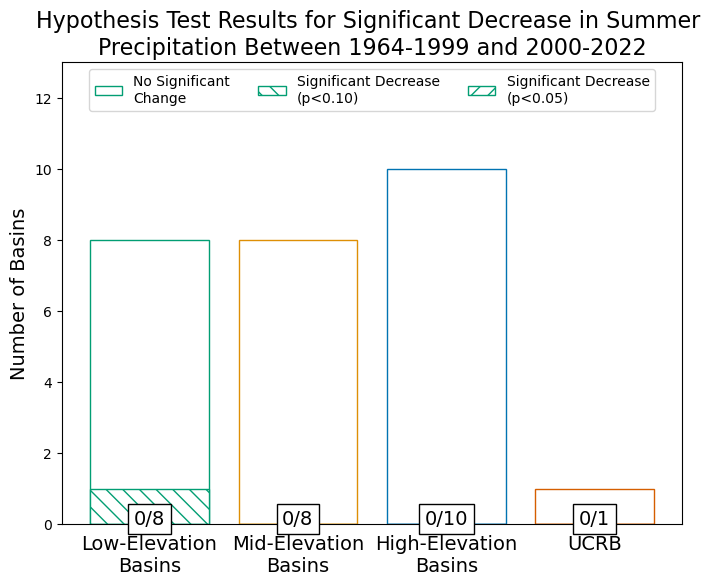

In [73]:
# create a dataframe with the results
low_rejected = len(low_summerp_ttest_results[(low_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_summerp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_summerp_ttest_results[(mid_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_summerp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_summerp_ttest_results[(high_summerp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_summerp_ttest_results['mannwhitney p']<0.05)])
summer_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='summer']
ucrb_rejected = len(summer_result[(summer_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (summer_result['mannwhitney p']<0.05)])
# calculate the same values but with 0.10 as the threshold
low_rejected_10 = len(low_summerp_ttest_results[(low_summerp_ttest_results['t-test p']<=0.10) |
                                               (low_summerp_ttest_results['mannwhitney p']<=0.10)])                                         
mid_rejected_10 = len(mid_summerp_ttest_results[(mid_summerp_ttest_results['t-test p']<=0.10) |
                                                   (mid_summerp_ttest_results['mannwhitney p']<=0.10)])    
high_rejected_10 = len(high_summerp_ttest_results[(high_summerp_ttest_results['t-test p']<=0.10) |
                                                         (high_summerp_ttest_results['mannwhitney p']<=0.10)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[8, 8, 10, 1], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'],
       height=[(low_rejected_10), (mid_rejected_10), (high_rejected_10),0],
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
           (0.8352941176470589, 0.3686274509803922, 0.0)],
       color=['white','white','white','white'],
       hatch='\\\\')

ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['none','none','none', 'none'], 
       hatch='//')
# add a legend with the hatch pattern
ax.legend(['No Significant\nChange', 'Significant Decrease\n(p<0.10)','Significant Decrease\n(p<0.05)'], ncols=3, loc='upper center', fontsize=10)
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Summer \nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=low_rejected, s=f'{low_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=1, y=mid_rejected, s=f'{mid_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=2, y=high_rejected, s=f'{high_rejected}/10', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=3, y=ucrb_rejected, s=f'{ucrb_rejected}/1', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.set_ylim(0,13)


(0.0, 13.0)

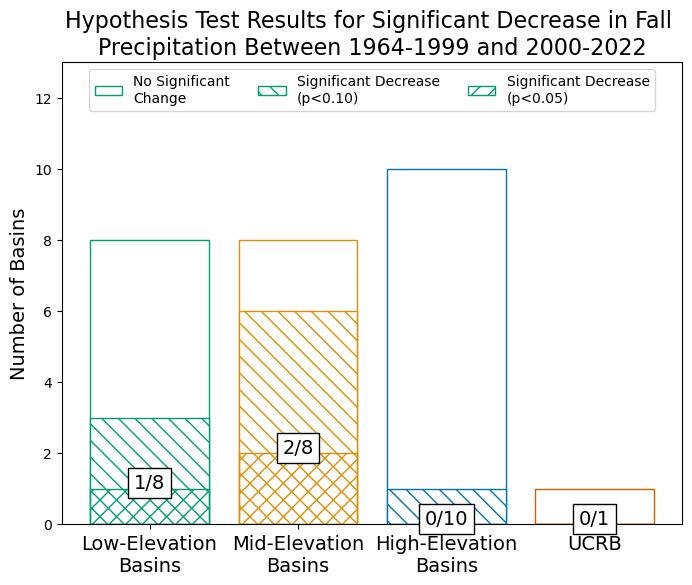

In [74]:
# create a dataframe with the results
low_rejected = len(low_fallp_ttest_results[(low_fallp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_fallp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_fallp_ttest_results[(mid_fallp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_fallp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_fallp_ttest_results[(high_fallp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_fallp_ttest_results['mannwhitney p']<0.05)])
fall_result = ucrb_seasonalppt_ttest_results[ucrb_seasonalppt_ttest_results.index=='fall']
ucrb_rejected = len(fall_result[(fall_result['t-test Result']=='Null Hypothesis Rejected') | 
                                         (fall_result['mannwhitney p']<0.05)])
# calculate the same values but with 0.10 as the threshold
low_rejected_10 = len(low_fallp_ttest_results[(low_fallp_ttest_results['t-test p']<=0.10) |
                                               (low_fallp_ttest_results['mannwhitney p']<=0.10)])                                         
mid_rejected_10 = len(mid_fallp_ttest_results[(mid_fallp_ttest_results['t-test p']<=0.10) |
                                                   (mid_fallp_ttest_results['mannwhitney p']<=0.10)])    
high_rejected_10 = len(high_fallp_ttest_results[(high_fallp_ttest_results['t-test p']<=0.10) |
                                                         (high_fallp_ttest_results['mannwhitney p']<=0.10)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[8, 8, 10, 1], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'],
       height=[(low_rejected_10), (mid_rejected_10), (high_rejected_10),0],
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
           (0.8352941176470589, 0.3686274509803922, 0.0)],
       color=['white','white','white','white'],
       hatch='\\\\')

ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['none','none','none', 'none'], 
       hatch='//')
# add a legend with the hatch pattern
ax.legend(['No Significant\nChange', 'Significant Decrease\n(p<0.10)','Significant Decrease\n(p<0.05)'], ncols=3, loc='upper center', fontsize=10)
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Fall \nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=low_rejected, s=f'{low_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=1, y=mid_rejected, s=f'{mid_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=2, y=high_rejected, s=f'{high_rejected}/10', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=3, y=ucrb_rejected, s=f'{ucrb_rejected}/1', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.set_ylim(0,13)


## Look at spring P and streamflow relationship

In [75]:
# Cluster monthly precipitation together
hcdn_monthly_prism_precip_ds = xr.open_dataset('../data/precipdata/hcdn_monthly_prism_precip.nc')
hcdn_monthly_prism_precip_ds = hcdn_monthly_prism_precip_ds.merge(basin_group_da)
high_monthly_ppt = hcdn_monthly_prism_precip_ds.where(hcdn_monthly_prism_precip_ds['predicted_cluster']==2, drop=True)
mid_monthly_ppt = hcdn_monthly_prism_precip_ds.where(hcdn_monthly_prism_precip_ds['predicted_cluster']==0, drop=True)
low_monthly_ppt = hcdn_monthly_prism_precip_ds.where(hcdn_monthly_prism_precip_ds['predicted_cluster']==1, drop=True)

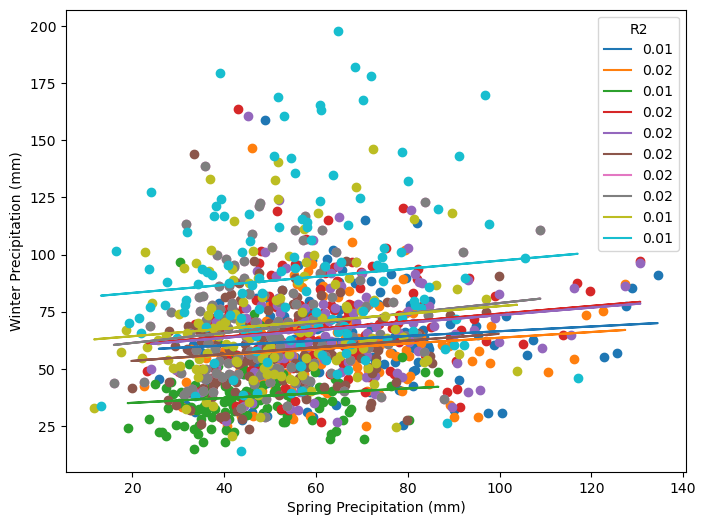

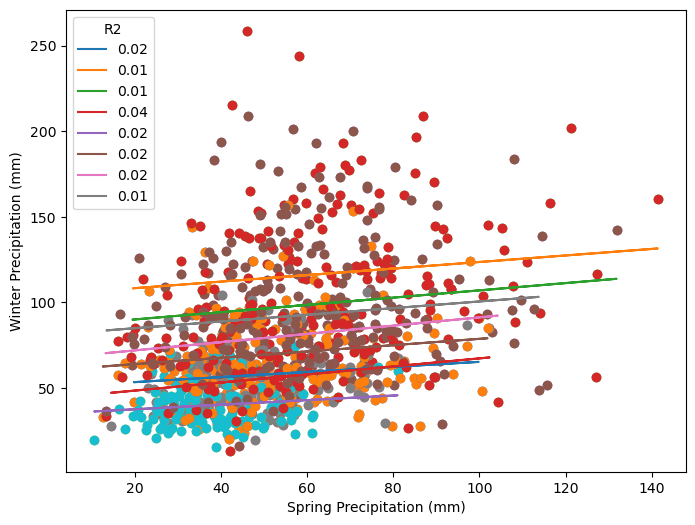

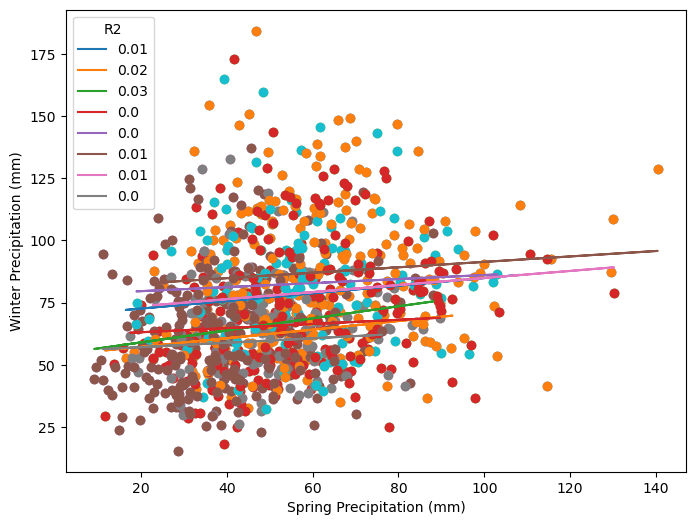

In [76]:
# plot high elevation seasonal precipitation for month = 4
# iterate through the site_no and plot the seasonal ppt vs annual q
# plot the seasonal ppt vs annual q for the site_no = 1
high_winter_spring_corr = []
fig, ax = plt.subplots(figsize=(8, 6))
for site in high_monthly_ppt.site_no:
    annualq = high_monthly_ppt.where((high_monthly_ppt['month'].dt.month.isin([1,2,3])), drop=True).ppt.sel(site_no=site)
    # add water year to annualq
    annualq['WY'] = annualq['month'].dt.year.where(annualq['month'].dt.month<10, annualq['month'].dt.year+1)
    annualq = annualq.groupby('WY').mean().values

    springp = high_monthly_ppt.where((high_monthly_ppt['month'].dt.month.isin([4,5,6])), drop=True).ppt.sel(site_no=site, )
    # add water year to springp
    springp['WY'] = springp['month'].dt.year.where(springp['month'].dt.month<10, springp['month'].dt.year+1)
    springp = springp.groupby('WY').mean().values
    plt.scatter(springp,
                annualq)
    # add a best fit line using linregress
    slope, intercept, r_value, p_value, std_err = stats.linregress(springp, annualq)
    plt.plot(springp, intercept + slope * springp, label=f'{round(r_value**2,2)}')
    high_winter_spring_corr.append(round(stats.spearmanr(springp,annualq)[0],2))
plt.ylabel('Winter Precipitation (mm)')
plt.xlabel('Spring Precipitation (mm)')
plt.legend(title='R2')

mid_winter_spring_corr = []
fig, ax = plt.subplots(figsize=(8, 6))
for site in mid_monthly_ppt.site_no:
    annualq = mid_monthly_ppt.where((mid_monthly_ppt['month'].dt.month.isin([1,2,3])), drop=True).ppt.sel(site_no=site)
    # add water year to annualq
    annualq['WY'] = annualq['month'].dt.year.where(annualq['month'].dt.month<10, annualq['month'].dt.year+1)
    annualq = annualq.groupby('WY').mean().values

    springp = mid_monthly_ppt.where((mid_monthly_ppt['month'].dt.month.isin([4,5,6])), drop=True).ppt.sel(site_no=site, )
    # add water year to springp
    springp['WY'] = springp['month'].dt.year.where(springp['month'].dt.month<10, springp['month'].dt.year+1)
    springp = springp.groupby('WY').mean().values
    plt.scatter(springp,
                annualq)
    plt.scatter(springp,
                annualq)
    slope, intercept, r_value, p_value, std_err = stats.linregress(springp, annualq)
    plt.plot(springp, intercept + slope * springp, label=f'{round(r_value**2,2)}')
    mid_winter_spring_corr.append(round(stats.spearmanr(springp,annualq)[0],2))
plt.legend(title='R2')
plt.ylabel('Winter Precipitation (mm)')
plt.xlabel('Spring Precipitation (mm)')

# figure for low elevation basins
low_winter_spring_corr = []
fig, ax = plt.subplots(figsize=(8, 6))
for site in low_monthly_ppt.site_no:
    annualq = low_monthly_ppt.where((low_monthly_ppt['month'].dt.month.isin([1,2,3])), drop=True).ppt.sel(site_no=site)
    # add water year to annualq
    annualq['WY'] = annualq['month'].dt.year.where(annualq['month'].dt.month<10, annualq['month'].dt.year+1)
    annualq = annualq.groupby('WY').mean().values

    springp = low_monthly_ppt.where((low_monthly_ppt['month'].dt.month.isin([4,5,6])), drop=True).ppt.sel(site_no=site, )
    # add water year to springp
    springp['WY'] = springp['month'].dt.year.where(springp['month'].dt.month<10, springp['month'].dt.year+1)
    springp = springp.groupby('WY').mean().values
    plt.scatter(springp,
                annualq)
    plt.scatter(springp,
                annualq)
    slope, intercept, r_value, p_value, std_err = stats.linregress(springp, annualq)
    plt.plot(springp, intercept + slope * springp, label=f'{round(r_value**2,2)}')
    low_winter_spring_corr.append(round(stats.spearmanr(springp,annualq)[0],2))
plt.ylabel('Winter Precipitation (mm)')
plt.xlabel('Spring Precipitation (mm)')
plt.legend(title='R2')

(0.0, 70.0)

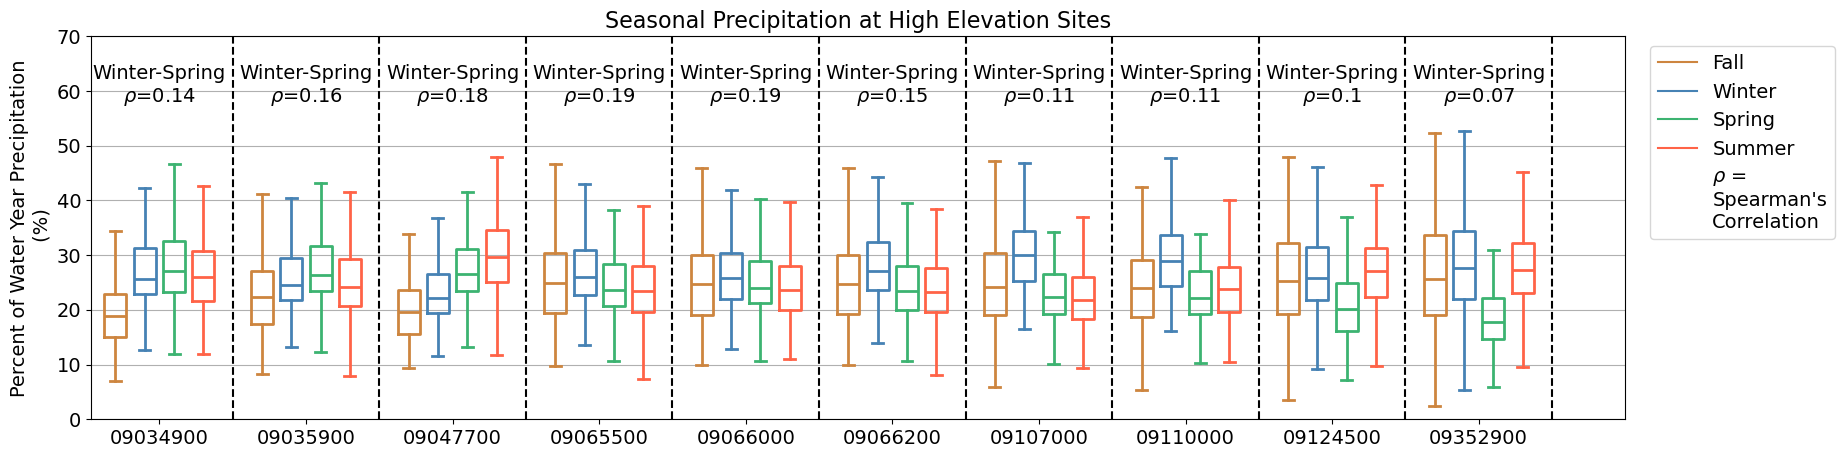

In [77]:
# create boxplot for high elevation data with a box
annual_ppt = high_elevation_annual_ppt.ppt
fall = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 10), drop=True).ppt.values.T/annual_ppt[:-1])
winter = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 1), drop=True).ppt.values.T/annual_ppt)
spring = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 4), drop=True).ppt.values.T/annual_ppt)
summer = 100*(high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 7), drop=True).ppt.values.T/annual_ppt)

ticks = high_elevation_seasonal_ppt.site_no.values

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color=color, linewidth=2)

plt.figure(figsize=(18,5))

fall_box = plt.boxplot(fall, positions=np.array(range(len(fall.T)))*3.-0.9, sym='', widths=0.45,)
winter_box = plt.boxplot(winter, positions=np.array(range(len(winter.T)))*3.-0.3, sym='', widths=0.45,)
spring_box = plt.boxplot(spring, positions=np.array(range(len(spring.T)))*3.+0.3, sym='', widths=0.45,)
summer_box = plt.boxplot(summer, positions=np.array(range(len(summer.T)))*3.+0.9, sym='', widths=0.45,)
# add vertical lines between each tick
for val in np.array(range(len(summer.T)))*3.+1.5:
    vertical_line = plt.axvline(x=val, color='k', linestyle='--')
# set box colors
set_box_color(fall_box, 'peru') # colors are from http://colorbrewer2.org/
set_box_color(winter_box, 'steelblue')
set_box_color(spring_box, 'mediumseagreen')
set_box_color(summer_box, 'tomato')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='peru', label='Fall')
plt.plot([], c='steelblue', label='Winter')
plt.plot([], c='mediumseagreen', label='Spring')
plt.plot([], c='tomato', label='Summer')
plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# set x-ticks
tick_spacing = np.linspace(0,len(ticks)*2+7,len(ticks))
plt.xticks(np.linspace(0,len(ticks)*2+7,len(ticks)), ticks, size=14)
# add the high_winter_spring_corr to the plot as text above each tick
for i, val in enumerate(high_winter_spring_corr):
    plt.text(tick_spacing[i], 58, "Winter-Spring\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# add horizontal grid lines
plt.grid(axis='y')
plt.tight_layout()
# increase y-axis label size 
plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# increase y-tick label size
plt.yticks(size=14)
plt.title('Seasonal Precipitation at High Elevation Sites', size=16)
plt.ylim(0,70)


In [78]:
# # import cycler
# from cycler import cycler
# # boxplots of precipitation by month 
# # create boxplot for high elevation data with a box
# annual_ppt = high_monthly_ppt.groupby('month.year').sum()['ppt']
# february = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 2), drop=True).ppt.values.T/annual_ppt)
# march = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 3), drop=True).ppt.values.T/annual_ppt)
# april = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 4), drop=True).ppt.values.T/annual_ppt)
# may = 100*(high_monthly_ppt.where((high_monthly_ppt['month'].dt.month == 5), drop=True).ppt.values.T/annual_ppt)

# ticks = high_monthly_ppt.site_no.values

# def set_box_color(bp, color):
#     plt.setp(bp['boxes'], color=color, linewidth=2)
#     plt.setp(bp['whiskers'], color=color, linewidth=2)
#     plt.setp(bp['caps'], color=color, linewidth=2)
#     plt.setp(bp['medians'], color=color, linewidth=2)

# plt.figure(figsize=(15,5))

# february_box = plt.boxplot(february, positions=np.array(range(len(february.T)))*3.-0.9, sym='', widths=0.45,)
# march_box = plt.boxplot(march, positions=np.array(range(len(march.T)))*3.-0.3, sym='', widths=0.45,)
# april_box = plt.boxplot(april, positions=np.array(range(len(april.T)))*3.+0.3, sym='', widths=0.45,)
# may_box = plt.boxplot(may, positions=np.array(range(len(may.T)))*3.+0.9, sym='', widths=0.45,)
# # add vertical lines between each tick
# for val in np.array(range(len(may.T)))*3.+1.5:
#     vertical_line = plt.axvline(x=val, color='k', linestyle='--')
# # create a colorcycler from the winter colormap
# cc = plt.cm.winter(np.linspace(0, 1,4))
# # set box colors
# set_box_color(february_box, cc[0]) # colors are from http://colorbrewer2.org/
# set_box_color(march_box, cc[1])
# set_box_color(april_box, cc[2])
# set_box_color(may_box, cc[3])

# # draw temporary red and blue lines and use them to create a legend
# plt.plot([], c=cc[0], label='February')
# plt.plot([], c=cc[1], label='March')
# plt.plot([], c=cc[2], label='April')
# plt.plot([], c=cc[3], label='May')
# plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
# plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# # set x-ticks
# tick_spacing = np.linspace(0,len(ticks)*2+2,len(ticks))
# plt.xticks(np.linspace(0,len(ticks)*2+2,len(ticks)), ticks, size=14)
# # add the high_march_april_corr to the plot as text above each tick
# for i, val in enumerate(high_march_april_corr):
#     plt.text(tick_spacing[i], 30, "March-April\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# # add horizontal grid lines
# plt.grid(axis='y')
# plt.tight_layout()
# # increase y-axis label size 
# plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# # increase y-tick label size
# plt.yticks(size=14)
# plt.title('Seasonal Precipitation at High Elevation Sites', size=16)
# plt.ylim(0,35)


(0.0, 70.0)

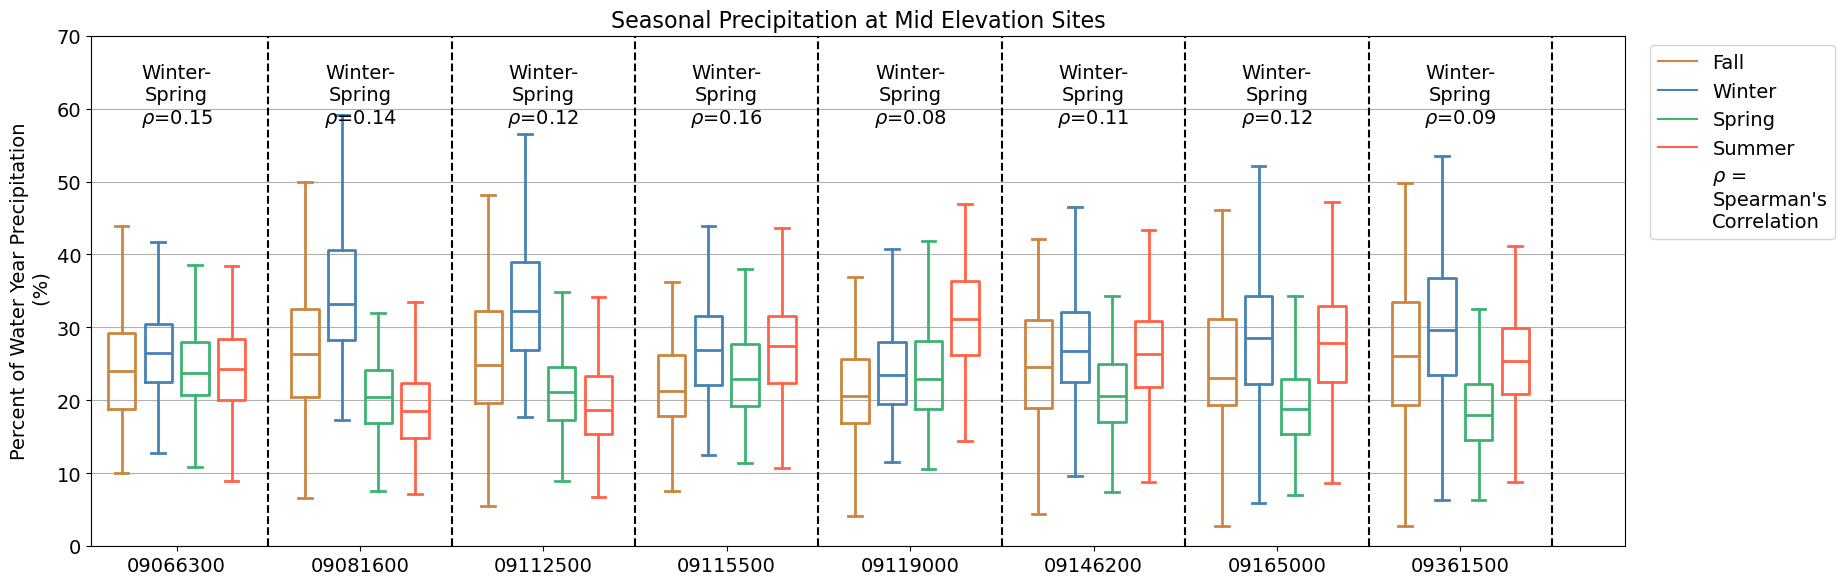

In [79]:
# create boxplot for mid elevation data with a box
annual_ppt = mid_elevation_annual_ppt.ppt
fall = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 10), drop=True).ppt.values.T/annual_ppt[:-1])
winter = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 1), drop=True).ppt.values.T/annual_ppt)
spring = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 4), drop=True).ppt.values.T/annual_ppt)
summer = 100*(mid_elevation_seasonal_ppt.where((mid_elevation_seasonal_ppt['month'].dt.month == 7), drop=True).ppt.values.T/annual_ppt)

ticks = mid_elevation_seasonal_ppt.site_no.values

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color=color, linewidth=2)

plt.figure(figsize=(18,6))

fall_box = plt.boxplot(fall, positions=np.array(range(len(fall.T)))*3.-0.9, sym='', widths=0.45,)
winter_box = plt.boxplot(winter, positions=np.array(range(len(winter.T)))*3.-0.3, sym='', widths=0.45,)
spring_box = plt.boxplot(spring, positions=np.array(range(len(spring.T)))*3.+0.3, sym='', widths=0.45,)
summer_box = plt.boxplot(summer, positions=np.array(range(len(summer.T)))*3.+0.9, sym='', widths=0.45,)
# add vertical lines between each tick
for val in np.array(range(len(summer.T)))*3.+1.5:
    vertical_line = plt.axvline(x=val, color='k', linestyle='--')
set_box_color(fall_box, 'peru') # colors are from http://colorbrewer2.org/
set_box_color(winter_box, 'steelblue')
set_box_color(spring_box, 'mediumseagreen')
set_box_color(summer_box, 'tomato')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='peru', label='Fall')
plt.plot([], c='steelblue', label='Winter')
plt.plot([], c='mediumseagreen', label='Spring')
plt.plot([], c='tomato', label='Summer')
plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# set x-ticks
tick_spacing = np.linspace(0,len(ticks)*2+5,len(ticks))
plt.xticks(tick_spacing, ticks, size=14)
# add the high_winter_spring_corr to the plot as text above each tick
for i, val in enumerate(mid_winter_spring_corr):
    plt.text(tick_spacing[i], 58, "Winter-\nSpring\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# add horizontal grid lines
plt.grid(axis='y')
plt.tight_layout()
# increase y-axis label size 
plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# increase y-tick label size
plt.yticks(size=14)
plt.title('Seasonal Precipitation at Mid Elevation Sites', size=16)
plt.ylim(0,70)


(0.0, 70.0)

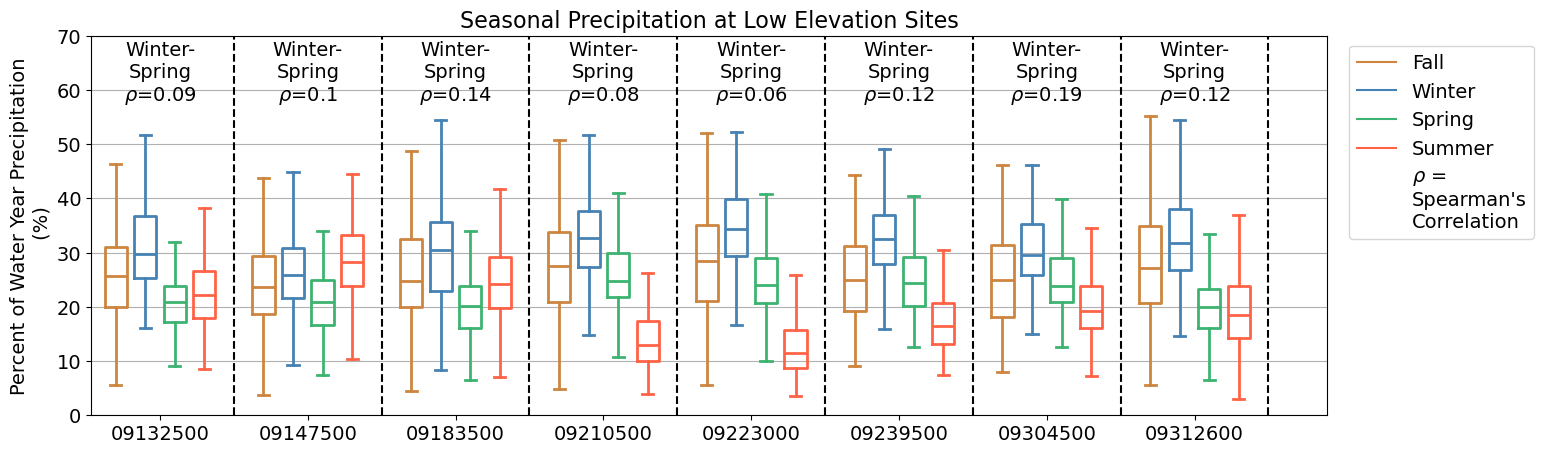

In [80]:
# create boxplot for low elevation data with a box
annual_ppt = low_elevation_annual_ppt.ppt
fall = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 10), drop=True).ppt.values.T/annual_ppt[:-1])
winter = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 1), drop=True).ppt.values.T/annual_ppt)
spring = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 4), drop=True).ppt.values.T/annual_ppt)
summer = 100*(low_elevation_seasonal_ppt.where((low_elevation_seasonal_ppt['month'].dt.month == 7), drop=True).ppt.values.T/annual_ppt)

ticks = low_elevation_seasonal_ppt.site_no.values

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color=color, linewidth=2)

plt.figure(figsize=(15,5))

fall_box = plt.boxplot(fall, positions=np.array(range(len(fall.T)))*3.-0.9, sym='', widths=0.45,)
winter_box = plt.boxplot(winter, positions=np.array(range(len(winter.T)))*3.-0.3, sym='', widths=0.45,)
spring_box = plt.boxplot(spring, positions=np.array(range(len(spring.T)))*3.+0.3, sym='', widths=0.45,)
summer_box = plt.boxplot(summer, positions=np.array(range(len(summer.T)))*3.+0.9, sym='', widths=0.45,)
# add vertical lines between each tick
for val in np.array(range(len(summer.T)))*3.+1.5:
    vertical_line = plt.axvline(x=val, color='k', linestyle='--')
set_box_color(fall_box, 'peru') # colors are from http://colorbrewer2.org/
set_box_color(winter_box, 'steelblue')
set_box_color(spring_box, 'mediumseagreen')
set_box_color(summer_box, 'tomato')


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='peru', label='Fall')
plt.plot([], c='steelblue', label='Winter')
plt.plot([], c='mediumseagreen', label='Spring')
plt.plot([], c='tomato', label='Summer')
plt.plot([], color='white', label=fr"$\rho$"+ " =\nSpearman's\nCorrelation")
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc='upper left')
# set x-ticks
tick_spacing = np.linspace(0,len(ticks)*2+5,len(ticks))
plt.xticks(tick_spacing, ticks, size=14)
# add the high_winter_spring_corr to the plot as text above each tick
for i, val in enumerate(low_winter_spring_corr):
    plt.text(tick_spacing[i], 58, "Winter-\nSpring\n"+fr"$\rho$={val}", horizontalalignment='center', size=14)
# add horizontal grid lines
plt.grid(axis='y')
plt.tight_layout()
# increase y-axis label size 
plt.ylabel('Percent of Water Year Precipitation\n (%)', size=14)
# increase y-tick label size
plt.yticks(size=14)
plt.title('Seasonal Precipitation at Low Elevation Sites', size=16)
plt.ylim(0,70)



### Look at residuals in the pre-2000 and post-2000s periods

In [81]:
def spearman_dataframe(annualq_data, ppt_data):
    # create a results dataframe
    results = pd.DataFrame(columns=['pre_springp_spearman', 'pre_winterp_spearman','post_springp_spearman', 'post_winterp_spearman', 
                                    'pre_summerp_spearman', 'pre_fallp_spearman', 'post_summerp_spearman', 'post_fallp_spearman',
                                    'pre_springp_winterp_spearman', 'post_springp_winterp_spearman'], 
                           index = ppt_data.site_no.values)
    # loop through each site
    for site in annualq_data.site_no.values:
        annualq = annualq_data.q_mm.sel(site_no=site).dropna(dim='WY')
        springp = ppt_data.where((ppt_data['month'].dt.month == 4) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        winterp = ppt_data.where((ppt_data['month'].dt.month == 1) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        summerp = ppt_data.where((ppt_data['month'].dt.month == 7) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        fallp = ppt_data.where((ppt_data['month'].dt.month == 10) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )                                            
        # split annualq into pre-2000 and post-2000
        annualq_pre = annualq.where(annualq.WY<2000,drop=True).values
        annualq_post = annualq.where(annualq.WY>=2000,drop=True).values
        # split springp into pre-2000 and post-2000
        springp_pre = springp.where(springp.month.dt.year<2000, drop=True)
        springp_post = springp.where(springp.month.dt.year>=2000, drop=True)
        # split winterp into pre-2000 and post-2000
        winterp_pre = winterp.where(winterp.month.dt.year<2000, drop=True)
        winterp_post = winterp.where(winterp.month.dt.year>=2000, drop=True)
        # split summerp into pre-2000 and post-2000
        summerp_pre = summerp.where(summerp.month.dt.year<2000, drop=True)
        summerp_post = summerp.where(summerp.month.dt.year>=2000, drop=True)
        # split fallp into pre-2000 and post-2000
        fallp_pre = fallp.where(fallp.month.dt.year<1999, drop=True)
        fallp_post = fallp.where((fallp.month.dt.year>=1999), drop=True)
        # calculate spearmans correlation for pre-2000
        pre_springp_spearman = stats.spearmanr(annualq_pre, springp_pre)
        pre_winterp_spearman = stats.spearmanr(annualq_pre, winterp_pre)
        pre_summerp_spearman = stats.spearmanr(annualq_pre, summerp_pre)
        pre_fallp_spearman = stats.spearmanr(annualq_pre, fallp_pre)
        pre_springp_winterp_spearman = stats.spearmanr(springp_pre, winterp_pre)
        # calculate spearmans correlation for post-2000
        post_springp_spearman = stats.spearmanr(annualq_post, springp_post)
        post_winterp_spearman = stats.spearmanr(annualq_post, winterp_post)
        post_summerp_spearman = stats.spearmanr(annualq_post, summerp_post)
        post_fallp_spearman = stats.spearmanr(annualq_post, fallp_post)
        post_springp_winterp_spearman = stats.spearmanr(springp_post, winterp_post)
        # store results in spearman_df
        results.loc[site] = [pre_springp_spearman[0], pre_winterp_spearman[0], post_springp_spearman[0], post_winterp_spearman[0],
                             pre_summerp_spearman[0], pre_fallp_spearman[0], post_summerp_spearman[0], post_fallp_spearman[0],
                             pre_springp_winterp_spearman[0], post_springp_winterp_spearman[0]]
    return results

In [82]:
high_spearman = spearman_dataframe(high_elevation_annual_q,high_elevation_seasonal_ppt)
mid_spearman = spearman_dataframe(mid_elevation_annual_q,mid_elevation_seasonal_ppt)
low_spearman = spearman_dataframe(low_elevation_annual_q,low_elevation_seasonal_ppt)

In [83]:
def spearman_dataframe_full(annualq_data, ppt_data):
    # create a results dataframe
    results_q = pd.DataFrame(columns=[ 'Winter P','Spring P',
                                    'Summer P', 'Antecedent\nFall P'], 
                           index = ppt_data.site_no.values)
    # create ppt_results dataframe
    results_ppt = pd.DataFrame(columns=[ 'winter_fall','winter_spring',
                                        'spring_summer','summer_fall'],
                            index = ppt_data.site_no.values)
    # loop through each site
    for site in annualq_data.site_no.values:
        annualq = annualq_data.q_mm.sel(site_no=site).dropna(dim='WY')
        springp = ppt_data.where((ppt_data['month'].dt.month == 4) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        winterp = ppt_data.where((ppt_data['month'].dt.month == 1) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        summerp = ppt_data.where((ppt_data['month'].dt.month == 7) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        fallp = ppt_data.where((ppt_data['month'].dt.month == 10) &
                                                    (ppt_data['year'].isin(annualq.WY.values)), drop=True).ppt.sel(site_no=site, )
        # split annualq into pre-2000 and post-2000
        annualq = annualq.where(annualq.WY>1963,drop=True).values
        # split springp into pre-2000 and post-2000
        springp = springp.where(springp.month.dt.year>1963, drop=True)
        # split winterp into pre-2000 and post-2000
        winterp = winterp.where((winterp.month.dt.year>1963), drop=True)
        # split summerp into pre-2000 and post-2000
        summerp = summerp.where(summerp.month.dt.year>1963, drop=True)
        # split fallp into pre-2000 and post-2000
        fallp = fallp.where((fallp.month.dt.year>=1963) & (fallp.month.dt.year<2022), drop=True)
        # calculate spearmans correlation for entire record
        springp_spearman = stats.pearsonr(annualq, springp)
        winterp_spearman = stats.pearsonr(annualq, winterp)
        summerp_spearman = stats.pearsonr(annualq, summerp)
        fallp_spearman = stats.pearsonr(annualq, fallp)
        # calculate spearmans between seasonal precipitation
        fallp_winterp_spearman = stats.pearsonr(fallp, winterp)
        winterp_springp_spearman = stats.pearsonr(winterp, springp)
        springp_summerp_spearman = stats.pearsonr(springp, summerp)
        summerp_fallp_spearman = stats.pearsonr(summerp, fallp)
        # store results in spearman_df
        results_q.loc[site] = [springp_spearman[0], winterp_spearman[0],
                             summerp_spearman[0], fallp_spearman[0]]
        # store results in results2
        results_ppt.loc[site] = [fallp_winterp_spearman[0], winterp_springp_spearman[0],
                                 springp_summerp_spearman[0], summerp_fallp_spearman[0]]
    return results_q

In [84]:
annualq = high_elevation_annual_q.q_mm.isel(site_no=1).dropna(dim='WY')
a = high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 4) &
                                (high_elevation_seasonal_ppt['year'].isin(annualq.WY.values)), drop=True).ppt.isel(site_no=1)
b = high_elevation_seasonal_ppt.where((high_elevation_seasonal_ppt['month'].dt.month == 1) &
                                (high_elevation_seasonal_ppt['year'].isin(annualq.WY.values)), drop=True).ppt.isel(site_no=1)

In [85]:
high_spearman = spearman_dataframe_full(high_elevation_annual_q,high_elevation_seasonal_ppt)
mid_spearman = spearman_dataframe_full(mid_elevation_annual_q,mid_elevation_seasonal_ppt)
low_spearman = spearman_dataframe_full(low_elevation_annual_q,low_elevation_seasonal_ppt)

In [86]:
# concatenate with mid_spearman
all_spearman = pd.concat([high_spearman, mid_spearman,low_spearman], axis=0)
# convert values to float
all_spearman = all_spearman.astype(float)
# get all columns that contain the word pre
pre_columns = [col for col in all_spearman.columns if 'pre' in col][:-1]
post_columns = [col for col in all_spearman.columns if 'post' in col][:-1]

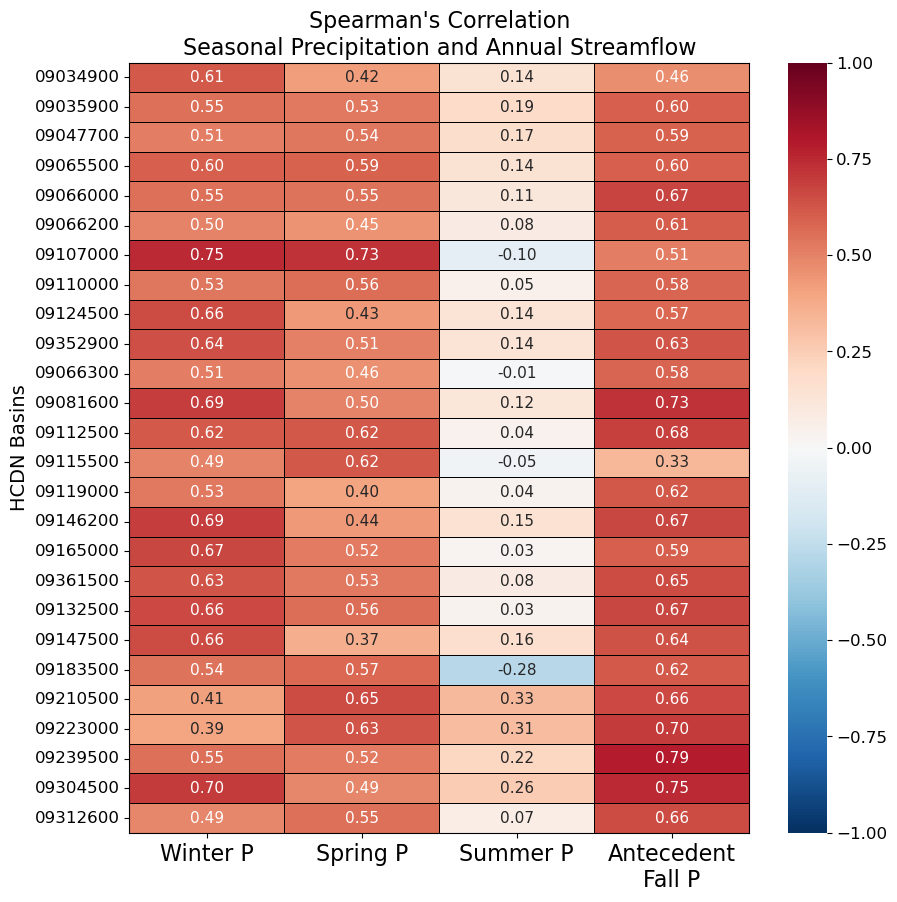

In [87]:
# concatenate with mid_spearman
all_spearman = pd.concat([high_spearman, mid_spearman,low_spearman], axis=0)
# convert values to float
all_spearman = all_spearman.astype(float)

# all_spearman_pre = all_spearman[pre_columns]
# # rename columns to be "Winter P", "Spring P", "Summer P", "Antecedent Fall P"
# all_spearman_pre = all_spearman_pre.rename(columns=dict(zip(all_spearman_pre.columns,["Winter P", "Spring P", "Summer P", "Antecedent Fall\nP"])))

# all_spearman_post = all_spearman[post_columns]
# # rename columns to be "Winter Q", "Spring Q", "Summer Q", "Antecedent Fall Q"
# all_spearman_post = all_spearman_post.rename(columns=dict(zip(all_spearman_post.columns,["Winter P", "Spring P", "Summer P", "Antecedent Fall\nP"])))

# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(all_spearman, vmin=-1, vmax=1, cmap='RdBu_r', annot=True, fmt='.2f', annot_kws={"size": 11}, linecolor='k', linewidths=0.5, ax=ax)
# add title "Seasonal Precipitation Spearman's Correlation to Annual Streamflow"
ax.set_title("Spearman's Correlation\nSeasonal Precipitation and Annual Streamflow", fontsize=16)
# increase font size of tick lables
ax.tick_params(labelsize=12)
# increase font size of x-tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16)
ax.set_ylabel("HCDN Basins", fontsize=14)
# increase the font size of the colorbar labels
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# rotate x-tick labels
# plt.xticks(rotation=45, ha='right')
# add frame around plot
for _, spine in ax.spines.items():
    spine.set_visible(True)
    




# Hypothesis testing for change in the amount of annual precipitation in pre- and post-2000 periods

1) High Elevation Basins

In [88]:
high_annualp_ttest_results = pd.DataFrame(index=high_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in high_elevation_annual_ppt.site_no.values:
    minyear = high_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (high_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = (high_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        high_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    high_annualp_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    high_annualp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [89]:
high_annualp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09034900,0.442516,Probably Gaussian,0.408,Null Hypothesis Accepted,NaN,NaN,-0.93,-7.13
09035900,0.636219,Probably Gaussian,0.487,Null Hypothesis Accepted,NaN,NaN,-0.13,-0.94
09047700,0.277287,Probably Gaussian,0.812,Null Hypothesis Accepted,NaN,NaN,3.78,18.84
09065500,0.458158,Probably Gaussian,0.407,Null Hypothesis Accepted,NaN,NaN,-1.03,-8.23
09066000,0.457203,Probably Gaussian,0.401,Null Hypothesis Accepted,NaN,NaN,-1.1,-8.85
09066200,0.376326,Probably Gaussian,0.658,Null Hypothesis Accepted,NaN,NaN,1.75,12.54
09107000,0.284448,Probably Gaussian,0.01,Null Hypothesis Rejected,NaN,NaN,-9.39,-70.85
09110000,0.223627,Probably Gaussian,0.029,Null Hypothesis Rejected,NaN,NaN,-7.7,-53.22
09124500,0.09449,Probably Gaussian,0.007,Null Hypothesis Rejected,NaN,NaN,-10.56,-80.95
09352900,0.499938,Probably Gaussian,0.003,Null Hypothesis Rejected,NaN,NaN,-13.39,-129.69


2) Mid Elevation Basins

In [90]:
mid_annualp_ttest_results = pd.DataFrame(index=mid_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_ppt.site_no.values:
    minyear = mid_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (mid_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = (mid_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        mid_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        mid_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            mid_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    mid_annualp_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    mid_annualp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [91]:
mid_annualp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09066300,0.165788,Probably Gaussian,0.827,Null Hypothesis Accepted,NaN,NaN,3.99,23.0
09081600,0.937484,Probably Gaussian,0.006,Null Hypothesis Rejected,NaN,NaN,-10.86,-111.42
09112500,0.374255,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN,-12.82,-120.11
09115500,0.870051,Probably Gaussian,0.007,Null Hypothesis Rejected,NaN,NaN,-9.88,-62.87
09119000,0.711757,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN,-10.5,-53.7
09146200,0.275587,Probably Gaussian,0.01,Null Hypothesis Rejected,NaN,NaN,-9.81,-74.73
09165000,0.094848,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN,-12.82,-107.39
09361500,0.143932,Probably Gaussian,0.003,Null Hypothesis Rejected,NaN,NaN,-12.81,-117.08


3) Low Elevation Basins

In [92]:
low_annualp_ttest_results = pd.DataFrame(index=low_elevation_annual_ppt.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_ppt.site_no.values:
    minyear = low_elevation_annual_ppt['ppt'].sel(site_no=site).to_pandas().dropna().index.min()
    single_site_pre = (low_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[test_start_year:1999])
    single_site_post = (low_elevation_annual_ppt.sel(site_no=site)['ppt'].to_pandas().dropna().loc[2000:])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_annualp_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='greater')
        low_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    low_annualp_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    low_annualp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [93]:
low_annualp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09132500,0.574237,Probably Gaussian,0.028,Null Hypothesis Rejected,NaN,NaN,-8.14,-62.09
09147500,0.315093,Probably Gaussian,0.008,Null Hypothesis Rejected,NaN,NaN,-9.93,-68.22
09183500,0.956135,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN,-13.21,-90.65
09210500,0.354881,Probably Gaussian,0.041,Null Hypothesis Rejected,NaN,NaN,-9.23,-56.44
09223000,0.433027,Probably Gaussian,0.056,Null Hypothesis Accepted,NaN,NaN,-8.38,-62.91
09239500,0.827164,Probably Gaussian,0.022,Null Hypothesis Rejected,NaN,NaN,-8.54,-70.61
09304500,0.466386,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN,-13.59,-111.78
09312600,0.683787,Probably Gaussian,0.122,Null Hypothesis Accepted,NaN,NaN,-6.1,-34.61


4. Upper Colorado River Basin

In [94]:
ucrb_annual_ppt = ucrb_ppt_seasonal_mean.groupby('WY').sum()
ucrb_annual_ppt_ttest_results = pd.DataFrame(index=['UCRB'], columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'percent change',
                                                                                    'value difference'
                                                                                    ])
single_site_pre = (ucrb_annual_ppt['ppt'].to_pandas().loc[1896:1999])
# for single site take remove the bottom and top 5% of values
single_site_post = (ucrb_annual_ppt['ppt'].to_pandas().loc[2000:])
# Example of the Shapiro-Wilk Normality Test
stat, p = stats.shapiro(single_site_pre)
ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke p'] = p

if p > conf:
    ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian'
    
    z_alpha = stats.norm.ppf(conf)
    # print("z_alpha = {}".format(z_alpha)) 

    s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                    (single_site_post.std(ddof=1)**2)/len(single_site_post))
    # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

    # null hypothesis: no change in sample means
    delta = 0*single_site_pre.mean()
    # compute test statistic
    z_test = ((single_site_post.mean()-single_site_pre.mean())-
            delta)/s_pooled
    # print("z-score = {}".format(np.round(z_test,2))) 
    # compute p value
    pvalue = stats.norm.cdf(z_test)
    ucrb_annual_ppt_ttest_results.loc['UCRB','t-test p'] = np.round(pvalue,3)
    if pvalue < conf:
        ucrb_annual_ppt_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_annual_ppt_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Accepted'
else:
    ucrb_annual_ppt_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
    stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney p'] = np.round(p_value,3)
    if p_value < conf:
        ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_annual_ppt_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Accepted'
ucrb_annual_ppt_ttest_results.loc['UCRB','percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,2)
ucrb_annual_ppt_ttest_results.loc['UCRB','value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [95]:
ucrb_annual_ppt_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,percent change,value difference
UCRB,0.251563,Probably Gaussian,0.072,Null Hypothesis Accepted,NaN,-5.42,-20.92


### Annual Precipitation Shift Plots

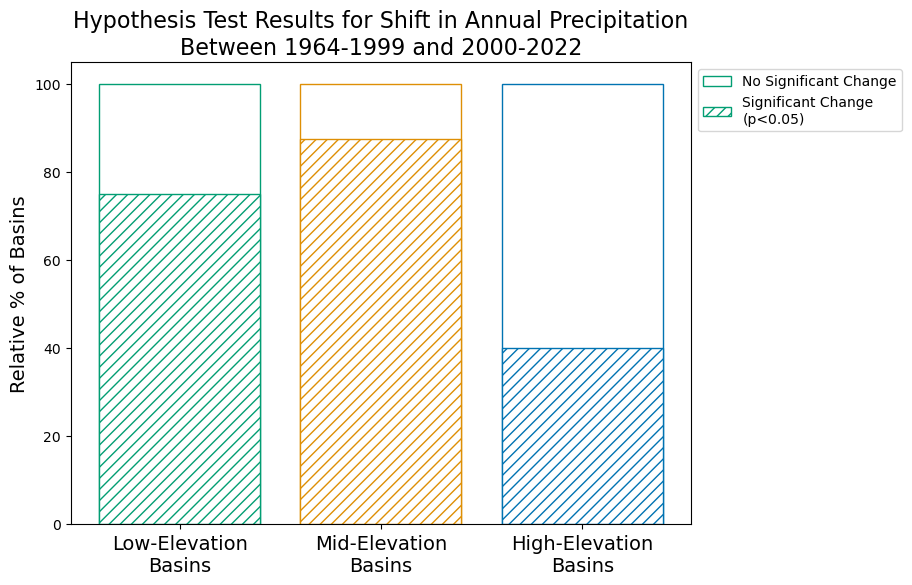

In [96]:

# create a dataframe with the results
low_rejected = len(low_annualp_ttest_results[(low_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_annualp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_annualp_ttest_results[(mid_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_annualp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_annualp_ttest_results[(high_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_annualp_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100, 100, 100], 
       ec=sns.color_palette("colorblind", 3)[::-1], 
       color=['white','white','white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins'], 
       height=[100*(low_rejected/8), 100*(mid_rejected/8), 100*(high_rejected/10)], 
       ec=sns.color_palette("colorblind", 3)[::-1], 
       color=['white','white','white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Relative % of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Shift in Annual Precipitation\nBetween {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)

(0.0, 13.0)

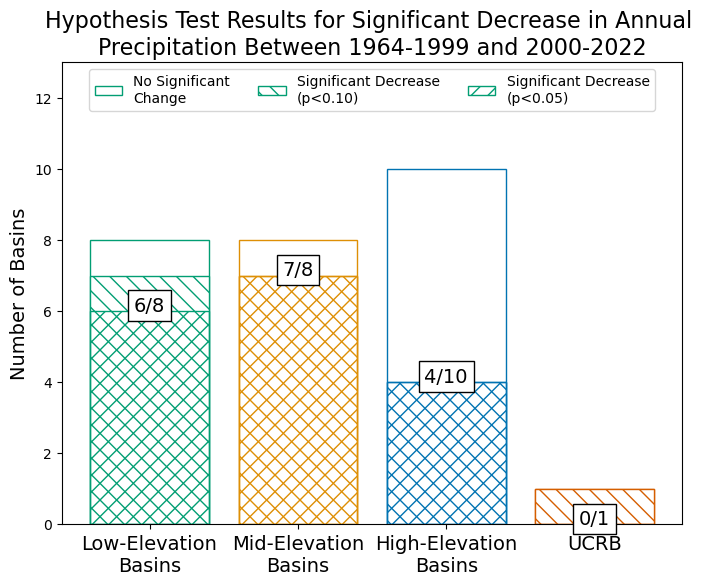

In [97]:

# create a dataframe with the results
low_rejected = len(low_annualp_ttest_results[(low_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_annualp_ttest_results['mannwhitney p']<0.05)])
mid_rejected = len(mid_annualp_ttest_results[(mid_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (mid_annualp_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_annualp_ttest_results[(high_annualp_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_annualp_ttest_results['mannwhitney p']<0.05)])
ucrb_rejected = len(ucrb_annual_ppt_ttest_results[(ucrb_annual_ppt_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (ucrb_annual_ppt_ttest_results['mannwhitney p']<0.05)])
# calculate the same values but with 0.10 as the threshold
low_rejected_10 = len(low_annualp_ttest_results[(low_annualp_ttest_results['t-test p']<=0.10) |
                                               (low_annualp_ttest_results['mannwhitney p']<=0.10)])                                         
mid_rejected_10 = len(mid_annualp_ttest_results[(mid_annualp_ttest_results['t-test p']<=0.10) |
                                                   (mid_annualp_ttest_results['mannwhitney p']<=0.10)])    
high_rejected_10 = len(high_annualp_ttest_results[(high_annualp_ttest_results['t-test p']<=0.10) |
                                                         (high_annualp_ttest_results['mannwhitney p']<=0.10)])
# create a stacked bar chart with low, mid, and high elevation sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins', 'UCRB'], 
       height=[8, 8, 10, 1], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['white','white','white', 'white'])
ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'],
       height=[(low_rejected_10), (mid_rejected_10), (high_rejected_10),1],
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
           (0.8352941176470589, 0.3686274509803922, 0.0)],
       color=['white','white','white','white'],
       hatch='\\\\')

ax.bar(x=['Low-Elevation\nBasins','Mid-Elevation\nBasins','High-Elevation\nBasins','UCRB'], 
       height=[(low_rejected), (mid_rejected), (high_rejected), (ucrb_rejected)], 
       ec=[(0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
           (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),  
           (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),  
           (0.8352941176470589, 0.3686274509803922, 0.0)], 
       color=['none','none','none', 'none'], 
       hatch='//')
# add a legend with the hatch pattern to be below the plot
ax.legend(['No Significant\nChange', 'Significant Decrease\n(p<0.10)','Significant Decrease\n(p<0.05)'], ncols=3, loc='upper center', fontsize=10)
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Significant Decrease in Annual \nPrecipitation Between {test_start_year}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=low_rejected, s=f'{low_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=1, y=mid_rejected, s=f'{mid_rejected}/8', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=2, y=high_rejected, s=f'{high_rejected}/10', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.text(x=3, y=ucrb_rejected, s=f'{ucrb_rejected}/1', fontsize=14, ha='center', bbox=dict(facecolor='white', alpha=1.0, ec='k'))
ax.set_ylim(0,13)

### Percent Changes

In [98]:
high_spring_diff = (high_springp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference'])
high_summer_diff = (high_summerp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference'])
high_fall_diff = (high_fallp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference'])
high_winter_diff = (high_winterp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference'])
(high_spring_diff)/high_annualp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference']

09107000    0.399435
09110000    0.509207
09124500    0.421248
09352900    0.368571
Name: value difference, dtype: object

In [99]:
mid_spring_diff = (mid_springp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference'])
mid_summer_diff = (mid_summerp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference'])
mid_fall_diff = (mid_fallp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference'])
mid_winter_diff = (mid_winterp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference'])
(mid_spring_diff)/mid_annualp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference']

09081600    0.306947
09112500    0.334693
09115500    0.427867
09119000    0.467412
09146200    0.467015
09165000    0.378061
09361500    0.345917
Name: value difference, dtype: object

In [100]:
low_spring_diff = (low_springp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference'])
low_summer_diff = (low_summerp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference'])
low_fall_diff = (low_fallp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference'])
low_winter_diff = (low_winterp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference'])
(low_spring_diff)/(low_spring_diff+low_summer_diff+low_fall_diff+low_winter_diff)

09132500    0.390183
09147500    0.474489
09183500    0.406362
09210500    0.238262
09239500    0.329599
09304500    0.321945
Name: value difference, dtype: object

In [101]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

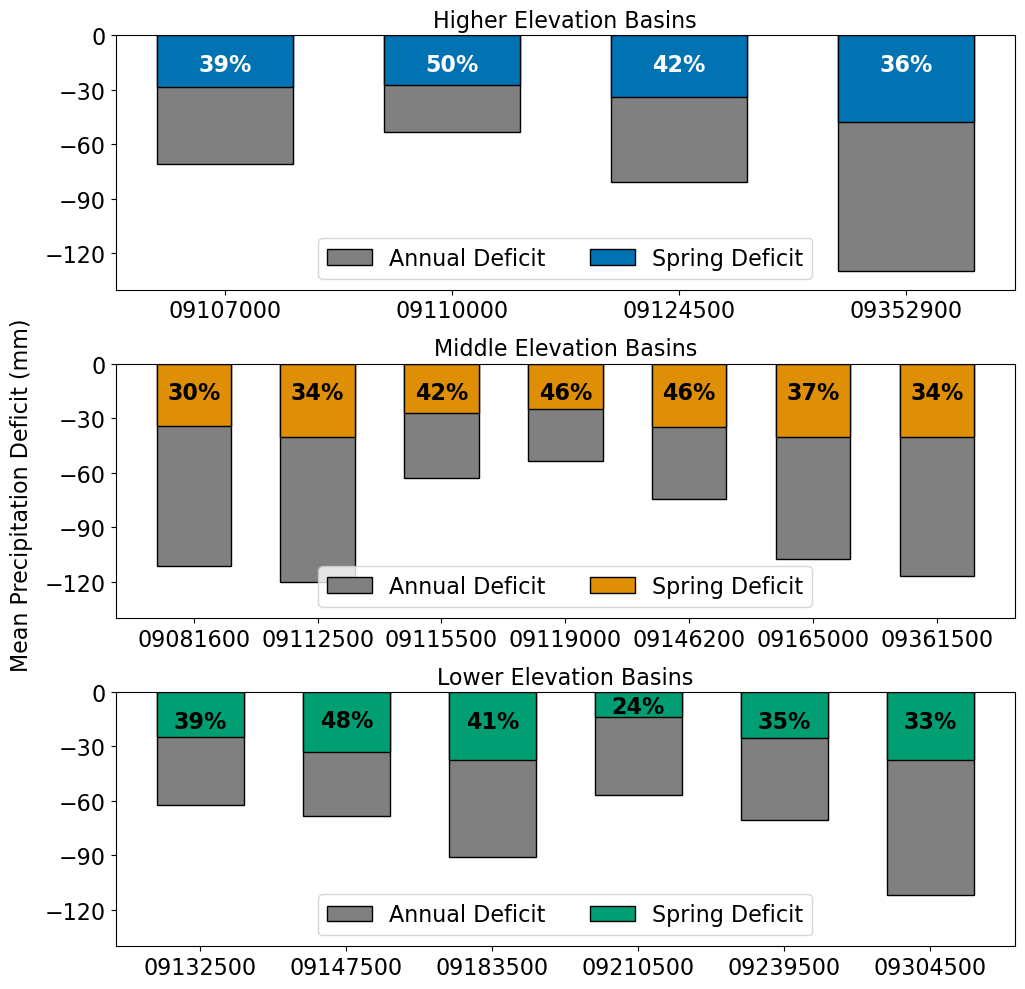

In [102]:
# create a bar plot with the value difference for high_annualp_ttest_results
fig, axs = plt.subplots(nrows=3,figsize=(10,10),tight_layout=True)
colors = sns.color_palette('colorblind')
ax = axs[0]
ax.bar(high_annualp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05].index, 
      high_annualp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference'],
      color='grey',
      width=0.6,
      ec='black',
      label = 'Annual Deficit')
ax.bar((high_spring_diff).index,
       (high_spring_diff),
       width=0.6,
       ec='black',
       color=colors[0], 
       label = 'Spring Deficit')
# add a label on each bar with the percent of total
for i, v in enumerate((high_spring_diff)/high_annualp_ttest_results[high_annualp_ttest_results['t-test p']<=0.05]['value difference']):
    ax.text(i, v - 20, str(int(100*v))+'%', color='white', fontweight='bold', fontsize=16, ha='center')
ax.set_title('Higher Elevation Basins', size=16)
# increase x tick label size
ax.tick_params(axis='x', labelsize=16, rotation=0)

# plot mid elevation basins
ax = axs[1]
ax.bar(mid_annualp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05].index, 
       mid_annualp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference'], 
       width=0.6,
       color='grey',
       ec='black',
       label = 'Annual Deficit')
ax.bar((mid_spring_diff).index, 
        (mid_spring_diff),
        width=0.6,
        color=colors[1], 
        ec='black',
        label = 'Spring Deficit')
# add a label on each bar with the percent of total
for i, v in enumerate((mid_spring_diff)/mid_annualp_ttest_results[mid_annualp_ttest_results['t-test p']<=0.05]['value difference']):
    if i == 1:
        ax.text(i, v-20, str(int(100*(v+0.0123)))+'%', color='black', fontweight='bold', fontsize=16, ha='center')
    else:
        ax.text(i, v-20, str(int(100*(v)))+'%', color='black', fontweight='bold', fontsize=16, ha='center')
ax.set_title('Middle Elevation Basins', size=16)

# add some space between title and plot
ax.title.set_position([.5, 1.1])


# plot low elevation basins
ax = axs[2]
ax.bar(low_annualp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05].index, 
       low_annualp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference'], 
       width=0.6,
       color='grey',
       ec='black',
       label = 'Annual Deficit')
ax.bar((low_spring_diff).index, 
       (low_spring_diff),
       width=0.6,
       color=colors[2],
       ec='black',
       label = 'Spring Deficit')
# add a label on each bar with the percent of total
for i, v in enumerate((low_spring_diff)/low_annualp_ttest_results[low_annualp_ttest_results['t-test p']<=0.05]['value difference']):
    if i ==3:
        ax.text(i, v -12, str(int(100*v))+'%', color='black', fontweight='bold', fontsize=16, ha='center')
    else:
        ax.text(i, v -20, str(int(100*v))+'%', color='black', fontweight='bold', fontsize=16, ha='center')
ax.set_title('Lower Elevation Basins', size=16)
# increase x tick label size
ax.tick_params(axis='x', labelsize=16, rotation=0)

# create a y-axis label for the entire figure
fig.text(-0.02, 0.5, 'Mean Precipitation Deficit (mm)', va='center', rotation='vertical', size=16)
# set ylim for all axes
for ax in axs:
    ax.set_ylim(-140, 0)
    # set ticks to be at 0, -30, -60, -90, -120
    ax.set_yticks(np.arange(0, -150, -30))
    # increase x tick label size
    ax.tick_params(axis='x', labelsize=16, rotation=0)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(ncols=2, fontsize=16, loc='lower center')
# fig.suptitle('Contribution of Spring Precipitation Deficit to Annual Precipitation Deficit in Basins with\nSignificant Decrease in Annual Precipitation Between Baseline and Millennium Drought', size=16)
# save figure at 700 dpi and 9x6 centimeters
fig.savefig('../figures/precip_deficit_contribution.png', dpi=700, pad_inches=0.2, bbox_inches='tight')


# Look at changes in runoff efficiency between periods

In [103]:
ucrb_annual_ppt = ucrb_ppt_seasonal_mean.groupby('WY').sum()
conf=0.05
ucrb_re_ttest_results = pd.DataFrame(index=['UCRB'], columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p'
                                                                                    ])
single_site_pre = (ucrb_naturalized_streamflow['q_mm_day'].loc[test_start_year:1999]/ucrb_annual_ppt['ppt'].to_pandas().loc[test_start_year:1999])
single_site_post = (ucrb_naturalized_streamflow['q_mm_day'].loc[2000:2022]/ucrb_annual_ppt['ppt'].to_pandas().loc[2000:2022])
# Example of the Shapiro-Wilk Normality Test
stat, p = stats.shapiro(single_site_pre)
ucrb_re_ttest_results.loc['UCRB','Shapiro-Wilke p'] = p

if p > conf:
    ucrb_re_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably Gaussian'
    
    z_alpha = stats.norm.ppf(conf)
    # print("z_alpha = {}".format(z_alpha)) 

    s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                    (single_site_post.std(ddof=1)**2)/len(single_site_post))
    # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

    # null hypothesis: no change in sample means
    delta = 0*single_site_pre.mean()
    # compute test statistic
    z_test = ((single_site_post.mean()-single_site_pre.mean())-
            delta)/s_pooled
    # print("z-score = {}".format(np.round(z_test,2))) 
    # compute p value
    pvalue = stats.norm.cdf(z_test)
    ucrb_re_ttest_results.loc['UCRB','t-test p'] = np.round(pvalue,3)
    if pvalue < conf:
        ucrb_re_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_re_ttest_results.loc['UCRB','t-test Result'] = 'Null Hypothesis Accepted'
else:
    ucrb_re_ttest_results.loc['UCRB','Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
    stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    ucrb_re_ttest_results.loc['UCRB','mannwhitney p'] = np.round(p_value,3)
    if p_value < conf:
        ucrb_re_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Rejected'
    else: 
        ucrb_re_ttest_results.loc['UCRB','mannwhitney Result'] = 'Null Hypothesis Accepted'

In [108]:
high_runoffeff_ttest_results = pd.DataFrame(index=high_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in high_elevation_annual_q.site_no.values:
    dataset_q = high_elevation_annual_q.where(high_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    dataset_p = high_elevation_annual_ppt.sel(site_no=site)
    single_site_pre = (dataset_q['q_mm']/dataset_p['ppt']).to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = (dataset_q['q_mm']/dataset_p['ppt']).to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_runoffeff_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        high_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        pvalue =  stats.ttest_ind(single_site_post, single_site_pre, equal_var=False)[1]
        high_runoffeff_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    
        high_runoffeff_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    high_runoffeff_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2)
    # Calculate the difference in the mean values between the two periods
    high_runoffeff_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2)

In [109]:

high_runoffeff_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09034900,0.424786,Probably Gaussian,0.032,Null Hypothesis Rejected,NaN,NaN,-9.05,-0.08
09035900,0.401196,Probably Gaussian,0.604,Null Hypothesis Accepted,NaN,NaN,-2.26,-0.01
09047700,0.437259,Probably Gaussian,0.024,Null Hypothesis Rejected,NaN,NaN,-12.83,-0.06
09065500,0.001716,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.017,Null Hypothesis Rejected,-11.13,-0.1
09066000,0.223814,Probably Gaussian,0.108,Null Hypothesis Accepted,NaN,NaN,-9.38,-0.06
09066200,0.094283,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN,-14.26,-0.13
09107000,0.816509,Probably Gaussian,0.372,Null Hypothesis Accepted,NaN,NaN,-4.73,-0.02
09110000,0.016216,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.008,Null Hypothesis Rejected,-12.5,-0.04
09124500,0.800356,Probably Gaussian,0.963,Null Hypothesis Accepted,NaN,NaN,-0.24,-0.0
09352900,0.47211,Probably Gaussian,0.444,Null Hypothesis Accepted,NaN,NaN,-3.35,-0.02


In [110]:
mid_runoffeff_ttest_results = pd.DataFrame(index=mid_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in mid_elevation_annual_q.site_no.values:
    dataset_q = mid_elevation_annual_q.where(mid_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    dataset_p = mid_elevation_annual_ppt.sel(site_no=site)
    single_site_pre = (dataset_q['q_mm']/dataset_p['ppt']).to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = (dataset_q['q_mm']/dataset_p['ppt']).to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    mid_runoffeff_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        mid_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        pvalue =  stats.ttest_ind(single_site_post, single_site_pre, equal_var=False)[1]
        mid_runoffeff_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            mid_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        mid_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    
        mid_runoffeff_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value[0],3)
        if p_value[0] < conf:
            mid_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            mid_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    mid_runoffeff_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2).values[0]
    # Calculate the difference in the mean values between the two periods
    mid_runoffeff_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2).values[0]

IndexError: invalid index to scalar variable.

In [111]:
mid_runoffeff_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09066300,0.049832,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,NaN,NaN,NaN,NaN
09081600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09112500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09115500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09119000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09146200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09165000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09361500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
low_runoffeff_ttest_results = pd.DataFrame(index=low_elevation_annual_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in low_elevation_annual_q.site_no.values:
    dataset_q = low_elevation_annual_q.where(low_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    dataset_p = low_elevation_annual_ppt.sel(site_no=site)
    single_site_pre = (dataset_q['q_mm']/dataset_p['ppt']).to_pandas().dropna().loc[test_start_year:1999]
    single_site_post = (dataset_q['q_mm']/dataset_p['ppt']).to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_runoffeff_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > conf:
        low_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        pvalue =  stats.ttest_ind(single_site_post, single_site_pre, equal_var=False)[1]
        low_runoffeff_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_runoffeff_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_runoffeff_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
    
        low_runoffeff_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value[0],3)
        if p_value[0] < conf:
            low_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_runoffeff_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'
    # Calculate the percent change between the two periods
    low_runoffeff_ttest_results.loc[site,'percent change'] = np.round(100*(single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean(),2).values[0]
    # Calculate the difference in the mean values between the two periods
    low_runoffeff_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),2).values[0]

AttributeError: 'numpy.float64' object has no attribute 'values'

In [113]:
low_runoffeff_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09132500,0.914995,Probably Gaussian,0.019,Null Hypothesis Rejected,NaN,NaN,NaN,NaN
09147500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09183500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09210500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09223000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09239500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09304500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09312600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
dataset_q.sel(WY=slice(1964,1999)).q_mm.dropna(dim='WY')

<xarray.DataArray 'q_mm' (WY: 36)>
array([240.69300655, 385.18562147, 226.19582791, 221.68228443,
       309.65959206, 322.60439888, 311.77727846, 296.84579465,
       199.22404063, 386.51545675, 290.76911145, 326.80926265,
       212.42368768,  74.44026647, 314.90355788, 404.57501464,
       443.15459487, 156.11297042, 358.57455874, 511.31897205,
       544.52178239, 520.37656806, 522.76345189, 345.47002811,
       203.15432303, 225.45104837, 137.23864166, 259.00202071,
       227.98329881, 502.94334285, 250.43795331, 529.74284378,
       315.02918335, 440.7336127 , 376.12623081, 237.54160203])
Coordinates:
    site_no  <U8 '09132500'
  * WY       (WY) int64 1964 1965 1966 1967 1968 ... 1995 1996 1997 1998 1999
    dim_1    <U9 'dayofyear'

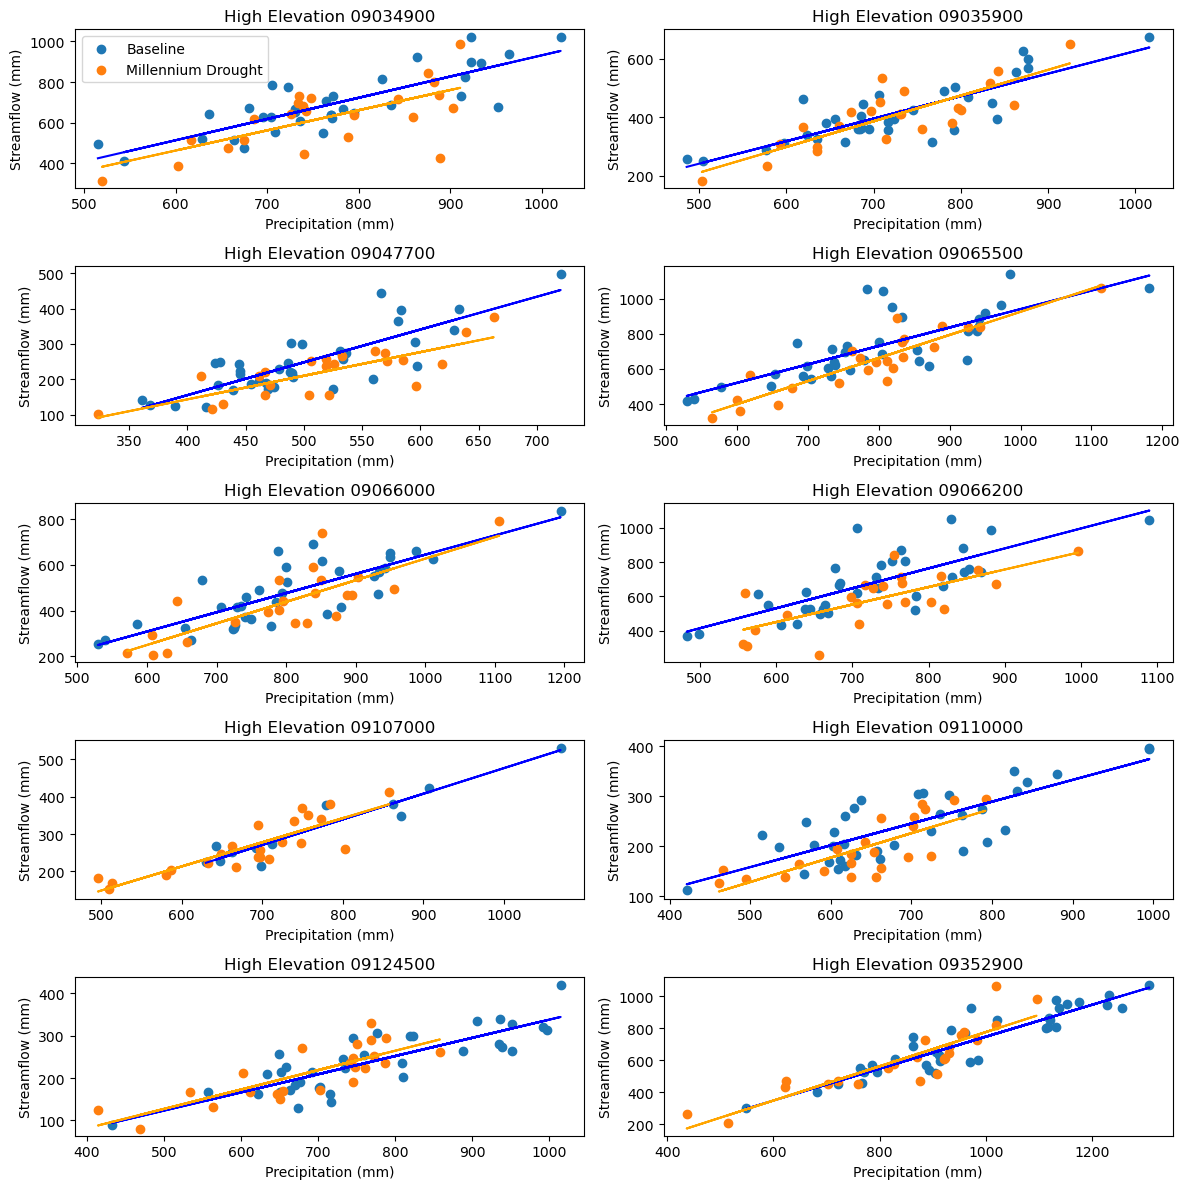

In [115]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,12), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(high_elevation_annual_q.site_no.values):
    dataset = high_elevation_annual_q.where(high_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    
    ax = axs[i]
    ax.scatter(dataset.sel(WY=slice(1964,1999)).ppt,
                dataset.sel(WY=slice(1964,1999)).q_mm, label='Baseline')
    
    
    # add a best fit line for each period
    x = dataset.sel(WY=slice(1964,1999)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(1964,1999)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='blue')
    ax.scatter(dataset.sel(WY=slice(2000,2022)).ppt,
                dataset.sel(WY=slice(2000,2022)).q_mm,label='Millennium Drought')
    # add a best fit line for each period
    x = dataset.sel(WY=slice(2000,2022)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(2000,2022)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='orange')
    ax.set_xlabel('Precipitation (mm)')
    ax.set_ylabel('Streamflow (mm)')
    ax.set_title(f'High Elevation {site}')
    if i==0:
        ax.legend()

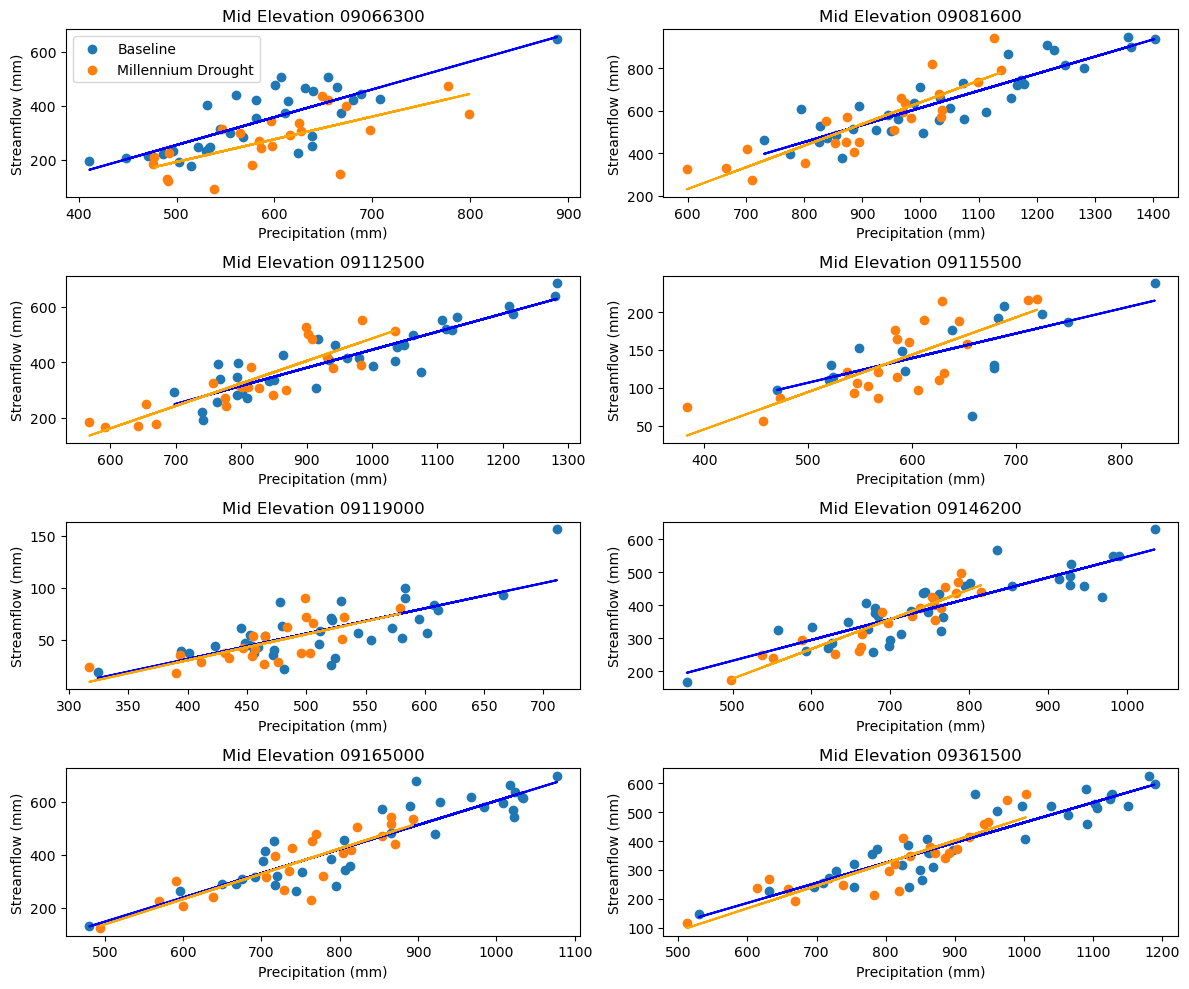

In [116]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,10), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(mid_elevation_annual_q.site_no.values):
    dataset = mid_elevation_annual_q.where(mid_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    # remove the WY with the least ppt
    dataset = dataset.where(dataset.ppt!=dataset.ppt.min(), drop=True)
    ax = axs[i]
    ax.scatter(dataset.sel(WY=slice(1964,1999)).ppt,
                dataset.sel(WY=slice(1964,1999)).q_mm, label='Baseline')
    
    
    # add a best fit line for each period
    x = dataset.sel(WY=slice(1964,1999)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(1964,1999)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='blue')
    ax.scatter(dataset.sel(WY=slice(2000,2022)).ppt,
                dataset.sel(WY=slice(2000,2022)).q_mm,label='Millennium Drought')
    # add a best fit line for each period
    x = dataset.sel(WY=slice(2000,2022)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(2000,2022)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='orange')
    ax.set_xlabel('Precipitation (mm)')
    ax.set_ylabel('Streamflow (mm)')
    ax.set_title(f'Mid Elevation {site}')
    if i==0:
        ax.legend()

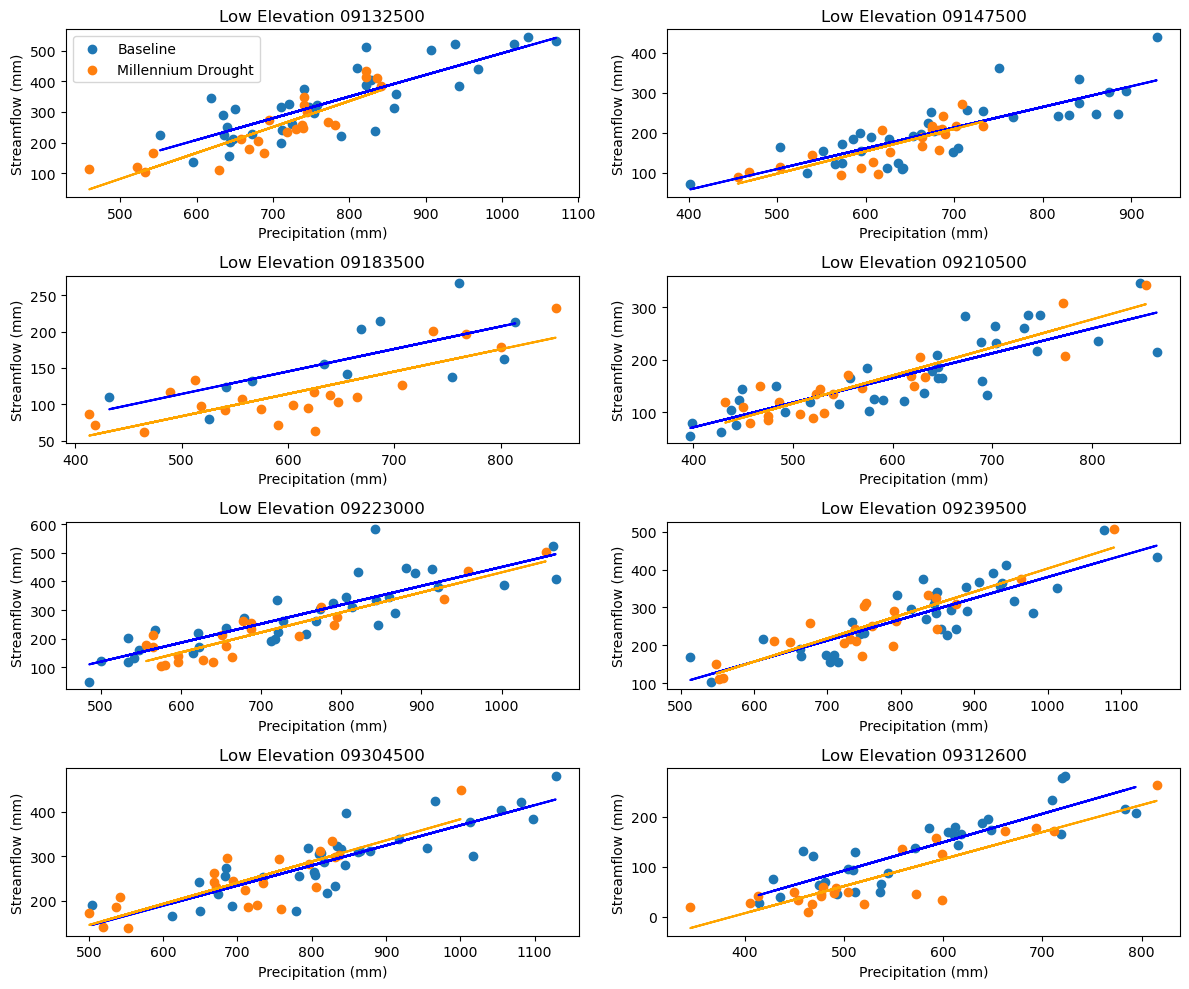

In [117]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,10), tight_layout=True)
axs = axs.flatten()
for i,site in enumerate(low_elevation_annual_q.site_no.values):
    dataset = low_elevation_annual_q.where(low_elevation_annual_q.q_mm>0, drop=True).sel(site_no=site)
    # remove the WY with the least ppt
    dataset = dataset.where(dataset.ppt!=dataset.ppt.min(), drop=True)
    ax = axs[i]
    ax.scatter(dataset.sel(WY=slice(1964,1999)).ppt,
                dataset.sel(WY=slice(1964,1999)).q_mm, label='Baseline')
    
    
    # add a best fit line for each period
    x = dataset.sel(WY=slice(1964,1999)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(1964,1999)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='blue')
    ax.scatter(dataset.sel(WY=slice(2000,2022)).ppt,
                dataset.sel(WY=slice(2000,2022)).q_mm,label='Millennium Drought')
    # add a best fit line for each period
    x = dataset.sel(WY=slice(2000,2022)).ppt.dropna(dim='WY')
    y = dataset.sel(WY=slice(2000,2022)).q_mm.dropna(dim='WY')
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='orange')
    ax.set_xlabel('Precipitation (mm)')
    ax.set_ylabel('Streamflow (mm)')
    ax.set_title(f'Low Elevation {site}')
    if i==0:
        ax.legend()

### Figure Mock Up

In [118]:
# get the sites in the high, mid and low meanq results that are Rejected
high_meanq_rejected = high_meanq_ttest_results[(high_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') |
                                                  (high_meanq_ttest_results['mannwhitney p']<0.05)].index.values 
mid_meanq_rejected = mid_meanq_ttest_results[(mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') |
                                                (mid_meanq_ttest_results['mannwhitney p']<0.05)].index.values      
low_meanq_rejected = low_meanq_ttest_results[(low_meanq_ttest_results['t-test Result']=='Null Hypothesis Rejected') |
                                                (low_meanq_ttest_results['mannwhitney p']<0.05)].index.values  
# combine these into a single array
all_meanq_rejected = np.concatenate((high_meanq_rejected, mid_meanq_rejected, low_meanq_rejected))     

# get the sites in the high, mid and low meanq results with t-test p-values >0.05 and less than 0.05
high_meanq_ttest_p10 = high_meanq_ttest_results[((high_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['t-test p']<=0.05)) |
                                                   ((high_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['mannwhitney p']<=0.05)) ].index.values
mid_meanq_ttest_p10 = mid_meanq_ttest_results[((mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['t-test p']<=0.05)) |
                                                    ((mid_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['mannwhitney p']<=
                                                     0.05)) ].index.values
low_meanq_ttest_p10 = low_meanq_ttest_results[((low_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['t-test p']<=0.05)) |
                                                    ((low_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['mannwhitney p']<=0.05)) ].index.values
# combine these into a single array
all_meanq_ttest_p10 = np.concatenate((high_meanq_ttest_p10, mid_meanq_ttest_p10, low_meanq_ttest_p10))

# get the sites in the high, mid and low meanq results with t-test p-values >0.05 and less than 0.05
high_meanq_ttest_acc = high_meanq_ttest_results[((high_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['t-test p']>0.05)) |
                                                   ((high_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (high_meanq_ttest_results['mannwhitney p']>0.05)) ].index.values
mid_meanq_ttest_acc = mid_meanq_ttest_results[((mid_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['t-test p']>0.05)) |
                                                    ((mid_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (mid_meanq_ttest_results['mannwhitney p']>0.05)) ].index.values
low_meanq_ttest_acc = low_meanq_ttest_results[((low_meanq_ttest_results['t-test Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['t-test p']>0.05)) |
                                                    ((low_meanq_ttest_results['mannwhitney Result']=='Null Hypothesis Accepted') &
                                                    (low_meanq_ttest_results['mannwhitney p']>0.05)) ].index.values
# combine these into a single array
all_meanq_ttest_acc = np.concatenate((high_meanq_ttest_acc, mid_meanq_ttest_acc, low_meanq_ttest_acc))

In [119]:
# get the sites in the high, mid, and low meanq percent change
high_meanq_percentchange = high_meanq_ttest_results['percent change']
mid_meanq_percentchange = mid_meanq_ttest_results['percent change']
low_meanq_percentchange = low_meanq_ttest_results['percent change']
# combine these into a single series
all_meanq_percentchange = pd.concat([high_meanq_percentchange, mid_meanq_percentchange, low_meanq_percentchange])

# get the sites in the high, mid and low springp results that are percent change
high_springp_percentchange = high_springp_ttest_results['percent change']
mid_springp_percentchange = mid_springp_ttest_results['percent change']
low_springp_percentchange = low_springp_ttest_results['percent change']
# combine these into a single series
all_springp_percentchange = pd.concat([high_springp_percentchange, mid_springp_percentchange, low_springp_percentchange])

# get the sites in the high, mid and low winterp results that are percent change
high_winterp_percentchange = high_winterp_ttest_results['percent change']
mid_winterp_percentchange = mid_winterp_ttest_results['percent change']
low_winterp_percentchange = low_winterp_ttest_results['percent change']
# combine these into a single series
all_winterp_percentchange = pd.concat([high_winterp_percentchange, mid_winterp_percentchange, low_winterp_percentchange])

# get the sites in the high, mid and low fallp results that are percent change
high_fallp_percentchange = high_fallp_ttest_results['percent change']
mid_fallp_percentchange = mid_fallp_ttest_results['percent change']
low_fallp_percentchange = low_fallp_ttest_results['percent change']
# combine these into a single series
all_fallp_percentchange = pd.concat([high_fallp_percentchange, mid_fallp_percentchange, low_fallp_percentchange])

# get the sites in the high, mid and low summerp results that are percent change
high_summerp_percentchange = high_summerp_ttest_results['percent change']
mid_summerp_percentchange = mid_summerp_ttest_results['percent change']
low_summerp_percentchange = low_summerp_ttest_results['percent change']
# combine these into a single series
all_summerp_percentchange = pd.concat([high_summerp_percentchange, mid_summerp_percentchange, low_summerp_percentchange])

# pull in the PRISM percent diff 
prism_springp_diff = xr.open_dataset('../data/precipdata/springP_prism_percentdiff.nc')

# Import DEM for hillshade

In [120]:
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource
src_4km = rxr.open_rasterio('../basin_characteristics/ucrb_dem_32613_150m.tif')
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)
# downsample to 800m
src_4km = src_4km.rio.reproject(dst_crs='EPSG:32613', resolution=3945.843241747955)
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)
ls = LightSource(azdeg=315, altdeg=45)
dx, dy =3945.843241747955,3945.843241747955

# Import HCDN basins

In [121]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')
# these two basins are especially difficult since they are small and extremely flashy and ephemeral. the last basin ended its record in the early 2000s
bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630']) 
hcdn_basins = hcdn_basins[~bad_gages]
hcdn_basins = hcdn_basins.set_crs(epsg='32613', allow_override=True)

(-148750.26486232155, 446464.52843976894, 3938943.52723589, 4823274.522415304)

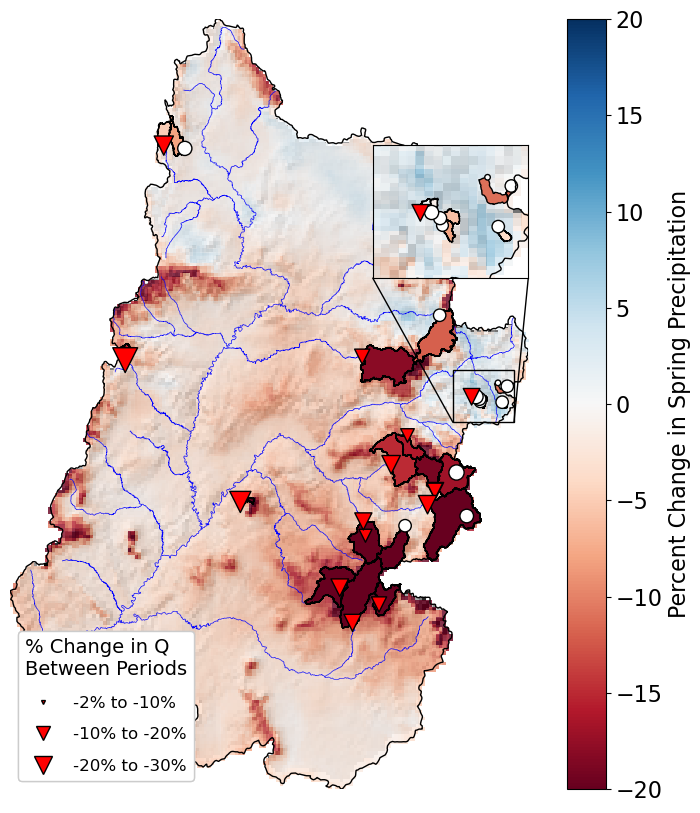

In [124]:
# import gage locations
gage_locations = gpd.read_file('../data/geodata/ucrb_hcdn_merged_gages.geojson')
# import hcdn basins
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
# filter basins in hcdn_daily_q
hcdn_basins = hcdn_basins[hcdn_basins['gage'].isin(hcdn_daily_q.site_no.values)]
hcdn_basins = hcdn_basins.set_crs('EPSG:32613', allow_override=True)
# set index col to be 'gage' column
hcdn_basins = hcdn_basins.set_index('gage')
# import the UCRB basin boundary
ucrb_basin = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
# set the crs to the same as hcdn basins
gage_locations = gage_locations.to_crs(hcdn_basins.crs)
ucrb_basin = ucrb_basin.to_crs(hcdn_basins.crs)

ucrb_stream_traces = gpd.read_file('../basin_characteristics/Colorado_River_Basin_Rivers.geojson')
ucrb_stream_traces = ucrb_stream_traces.to_crs(32613)
# clip to UCRB boundary
ucrb_stream_traces = gpd.clip(ucrb_stream_traces, ucrb_basin_boundary)

# add 0 to the beginning of the site_no to match the format in the hcdn_daily_q dataframe
gage_locations['STAID'] = '0' + gage_locations['STAID'].astype(str)
# filter out the gages not included in the analysis
gage_locations = gage_locations[gage_locations['STAID'].isin(hcdn_daily_q.site_no.values)]
# reset index
gage_locations = gage_locations.set_index('STAID')
# add all_meanq_percentchange as a column in the gage_locations dataframe
gage_locations['meanq_percentchange'] = np.abs(all_meanq_percentchange.astype(int))*8

# add all_springp_percentchange as a column in the hcdn_basins dataframe
hcdn_basins['springp_percentchange'] = (all_springp_percentchange.astype(int))

# create a fig and ax
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                            ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                            ucrb_basin_boundary.bounds.loc[0]['maxy']])
# plot the prism percent diff
im = ax.imshow(prism_springp_diff['ppt'].values,
                       cmap='RdBu',alpha=0.8, vmin=-20, vmax=20,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])               
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=0.5, zorder=1)    
# plot the hcdn basins
hcdn_basins.plot(ax=ax, 
                 column='springp_percentchange',
                 cmap='RdBu', 
                 edgecolor='black', 
                 linewidth=1,
                 vmin=-20, 
                 vmax=20)
# plot a legend for the colorbar
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-20, vmax=20))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Percent Change in Spring Precipitation', fontsize=16)
# increase ticklabel size on colorbar
cbar.ax.tick_params(labelsize=16)
# plot the ucrb basins
ucrb_basin.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# plot the gage location geometry with sizes based on all_meanq_percentchange
gage_locations[gage_locations.index.isin(all_meanq_ttest_acc)].plot(markersize=gage_locations[gage_locations.index.isin(all_meanq_ttest_acc)]['meanq_percentchange'], 
                    label='Decrease in Q (p$\geq$0.05)', 
                    marker='o', 
                    ax=ax, 
                    color='white', 
                    ec='k')
# plot gage locations with significant change in meanq                    
# gage_locations.loc[all_meanq_ttest_p10].plot(markersize=gage_locations.loc[all_meanq_ttest_p10]['meanq_percentchange'],
#                                             label='Decrease in Q (0.05$\leq$p<0.10)', 
#                                             marker='v', 
#                                             ax=ax, 
#                                             color='yellow', 
#                                             ec='k')
# plot gage locations with significant change in meanq                    
gage_locations.loc[all_meanq_rejected].plot(markersize=gage_locations.loc[all_meanq_rejected]['meanq_percentchange'],
                                            label='Decrease in Q (p<0.05)', 
                                            marker='v', 
                                            ax=ax, 
                                            color='red', 
                                            ec='k')
# make a inset map
axins = ax.inset_axes(bounds=[0.7,0.6,.3,.3])
axins.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'],
                                                                                                    ucrb_basin_boundary.bounds.loc[0]['maxx'],
                                                                                                    ucrb_basin_boundary.bounds.loc[0]['miny'],
                                                                                                    ucrb_basin_boundary.bounds.loc[0]['maxy']])
# plot the prism percent diff
axins.imshow(prism_springp_diff['ppt'].values,
                          cmap='RdBu',alpha=0.8, vmin=-20, vmax=20,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'],
                                                                            ucrb_basin_boundary.bounds.loc[0]['maxx'],          
                                                                            ucrb_basin_boundary.bounds.loc[0]['miny'],
                                                                            ucrb_basin_boundary.bounds.loc[0]['maxy']])
# plot the hcdn basins
hcdn_basins.plot(ax=axins,
                    column='springp_percentchange',
                    cmap='RdBu',
                    edgecolor='black',
                    linewidth=1,
                    vmin=-20,
                    vmax=20)

# plot the gage location geometry with sizes based on all_meanq_percentchange
gage_locations[gage_locations.index.isin(all_meanq_ttest_acc)].plot(markersize=gage_locations[gage_locations.index.isin(all_meanq_ttest_acc)]['meanq_percentchange'], 
                    label='Decrease in Q (p$\geq$0.05)', 
                    marker='o', 
                    ax=axins, 
                    color='white', 
                    ec='k')
# plot gage locations with significant change in meanq                    
# gage_locations.loc[all_meanq_ttest_p10].plot(markersize=gage_locations.loc[all_meanq_ttest_p10]['meanq_percentchange'],
#                                             label='Decrease in Q (0.05$\leq$p<0.10)', 
#                                             marker='v', 
#                                             ax=axins, 
#                                             color='yellow', 
#                                             ec='k')
# plot gage locations with significant change in meanq                    
gage_locations.loc[all_meanq_rejected].plot(markersize=gage_locations.loc[all_meanq_rejected]['meanq_percentchange'],
                                            label='Decrease in Q (p<0.05)', 
                                            marker='v', 
                                            ax=axins, 
                                            color='red', 
                                            ec='k')                    
# set the xlim and ylim for the inset map 
axins.set_xlim(3.6e5,4.3e5)
axins.set_ylim(4.36e6,4.42e6)
# hide x and y ticks
axins.set_xticks([])
axins.set_yticks([])
# draw a rectangle over the xlim ylim area
ax.indicate_inset_zoom(axins, edgecolor="black", lw=1, alpha=1)
# plot the ucrb basins
ucrb_basin.plot(ax=axins, color='none', edgecolor='black', linewidth=1)

# need to add existing legend back
leg1 = ax.legend(loc='upper right',framealpha=1, title='HCDN Gages',title_fontsize=14,fontsize=12,)
# create a second legend for the size of the gage locations
# some bins to indicate size in legend
_, bins = pd.cut(gage_locations['meanq_percentchange']/8, bins=[1,11,21], precision=0, retbins=True)
# create second legend
import matplotlib.lines as mlines
# create label for each bin with a range between the bin values
labels = ['-'+str(int(b-1))+'%'+' to '+'-'+str(int(bins[i]-1+10))+'%' for i, b in enumerate(bins)]
labels.append(str(int(bins[-1]))+'%+')
labels[0] = '-2'+'%'+' to '+'-'+str(int(bins[0]-1+10))+'%'
ax.add_artist(
    ax.legend(
        handles=[
            mlines.Line2D(
                [],
                [],
                color="red",
                lw=0,
                marker="v",
                markeredgecolor='k',
                markersize=np.sqrt(b*8),
                label=labels[i],
            )
            for i, b in enumerate(bins)
        ],
        loc='lower left',
        # make distance between legend items a bit bigger
        labelspacing=1,
        # add title to the legend
        title='% Change in Q\nBetween Periods',
        # increase title font size
        title_fontsize=14,
        fontsize=12,
        framealpha=1,
    )
)
# restore original legend
# ax.add_artist(leg1)
# remove axis labels
ax.axis('off')
# save figure at 700 dpi and 9x6 centimeters
# fig.savefig('../figures/spring_precip_streamflow_with_legends.png', dpi=700, pad_inches=0.1)

In [135]:
# add all_springp_percentchange as a column in the hcdn_basins dataframe
hcdn_basins['springp_percentchange'] = (all_springp_percentchange.astype(int))
hcdn_basins['winterp_percentchange'] = (all_winterp_percentchange.astype(int))
hcdn_basins['summerp_percentchange'] = (all_summerp_percentchange.astype(int))
hcdn_basins['fallp_percentchange'] = (all_fallp_percentchange.astype(int))

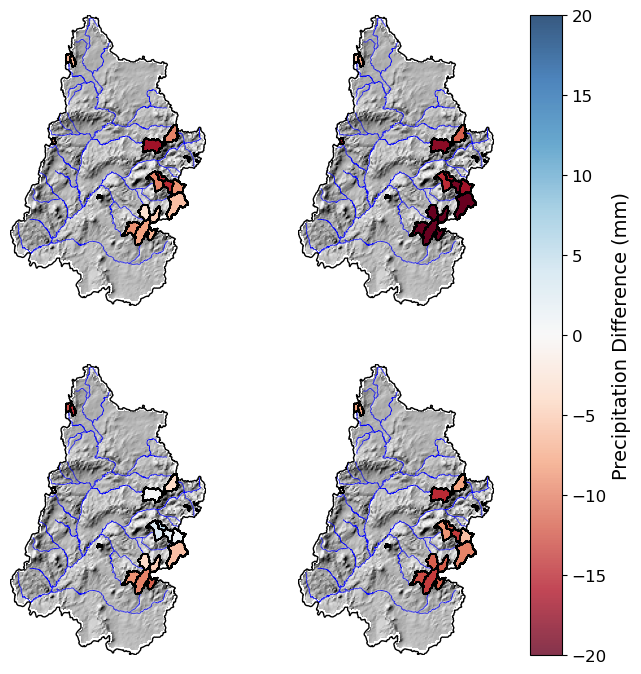

In [137]:


# create a fig and ax
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs = axs.ravel()
month_station_dict = {1:'winterp_percentchange',
                      4:'springp_percentchange',
                      7:'summerp_percentchange',
                      10:'fallp_percentchange'}
for i, month in enumerate(month_station_dict.keys()):
    ax=axs[i]
    ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                    ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                                ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                                ucrb_basin_boundary.bounds.loc[0]['maxy']])
    # # plot the prism percent diff
    # im = ax.imshow(prism_springp_diff['ppt'].values,
    #                     cmap='RdBu',alpha=0.8, vmin=-20, vmax=20,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
    #                                                                         ucrb_basin_boundary.bounds.loc[0]['maxx'], 
    #                                                                         ucrb_basin_boundary.bounds.loc[0]['miny'], 
    #                                                                         ucrb_basin_boundary.bounds.loc[0]['maxy']])               
    ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=0.5, zorder=1)    
    # plot the hcdn basins
    hcdn_basins.plot(ax=ax, 
                    column=month_station_dict[month],
                    cmap='RdBu', 
                    edgecolor='black', 
                    linewidth=1,
                    vmin=-20, 
                    vmax=20)
    # plot the ucrb basins
    ucrb_basin.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

    # remove axis labels
    ax.axis('off')
# create a colorbar for the entire ax5 with vmin=20 and vmax=40 and cmap='YlGnBu'
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0, hspace=0.2)
cbar = fig.colorbar(im, ax=axs)
cbar.set_label('Precipitation Difference (mm)', size=14)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=12)

# ANOVA testing for differences between basins in pre- and post-2000 streamflow

In [79]:
# Function to get the day of Water Year
def date2DOWY(day_of_interest):
    day_of_interest = pd.to_datetime(day_of_interest)
    if day_of_interest >= dt.datetime(day_of_interest.year,10,1):
        dowy_start = dt.datetime(day_of_interest.year,10,1)
    else: 
        dowy_start = dt.datetime(day_of_interest.year-1,10,1)
    dowy = day_of_interest - dowy_start
    return dowy.days
dates = [date2DOWY(x) for x in hcdn_daily_q.date.values]
dowy_da = pd.Series(dates,index=hcdn_daily_q.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_ds = hcdn_daily_q.copy()
hcdn_q_dowy_ds = hcdn_q_dowy_ds.merge(dowy_da)
hcdn_q_dowy_spsu_ds = hcdn_q_dowy_ds.where(hcdn_q_dowy_ds.date.dt.month.isin([3,4,5,6,7,8,9,10]), drop=True)

In [80]:
hcdn_q_dowy_pre2000_ds = hcdn_q_dowy_spsu_ds.where(hcdn_q_dowy_spsu_ds.WY<2000, drop=True)
dates = [date2DOWY(x) for x in hcdn_q_dowy_pre2000_ds.date.values]
dowy_da = pd.Series(dates,index=hcdn_q_dowy_pre2000_ds.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_pre2000_ds = hcdn_q_dowy_pre2000_ds.merge(dowy_da)

In [81]:
hcdn_q_dowy_post2000_ds = hcdn_q_dowy_spsu_ds.where(hcdn_q_dowy_spsu_ds.WY>=2000, drop=True)
dates = [date2DOWY(x) for x in hcdn_q_dowy_post2000_ds.date.values]
dowy_da = pd.Series(dates,index=hcdn_q_dowy_post2000_ds.date.values).to_xarray()
dowy_da.name = 'dowy'
dowy_da = dowy_da.rename({'index':'date'})

hcdn_q_dowy_post2000_ds = hcdn_q_dowy_post2000_ds.merge(dowy_da)

In [82]:
hcdn_q_dowy_mean = hcdn_q_dowy_spsu_ds.groupby('dowy').mean()
hcdn_q_dowy_pre2000_mean = hcdn_q_dowy_pre2000_ds.groupby('dowy').mean()
hcdn_q_dowy_post2000_mean = hcdn_q_dowy_post2000_ds.groupby('dowy').mean()

6.378322826263686
0.0017934681352298782


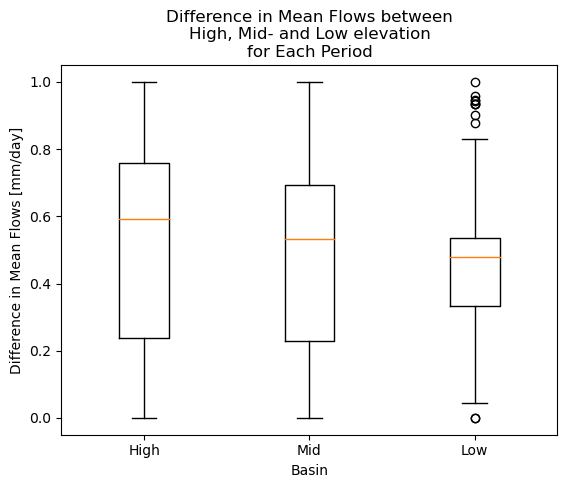

In [78]:
site_diff_high = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==2, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==2, drop=True).mean(dim='site_no')['q_mm_day']))
site_diff_mid = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==0, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==0, drop=True).mean(dim='site_no')['q_mm_day']))
site_diff_low = (np.log(hcdn_q_dowy_post2000_mean.where(hcdn_q_dowy_post2000_mean.predicted_cluster==1, drop=True).mean(dim='site_no')['q_mm_day']) - np.log(hcdn_q_dowy_pre2000_mean.where(hcdn_q_dowy_pre2000_mean.predicted_cluster==1, drop=True).mean(dim='site_no')['q_mm_day']))
# stats f_oneway functions takes the groups as input and returns an F and P-value
fvalue, pvalue = stats.f_oneway(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
                                ((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
                                ((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min())))
print(fvalue)
print(pvalue)
# Using boxplot, we can start to visually see differences between the periods
plt.boxplot([((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
                ((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
                ((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))],
           labels=['High', 'Mid', 'Low'])

# Add labels
plt.xlabel('Basin')
plt.ylabel('Difference in Mean Flows [mm/day]')
plt.title('Difference in Mean Flows between\nHigh, Mid- and Low elevation\nfor Each Period');

Prior to running our test, lets test to make sure our data is valid for using this test

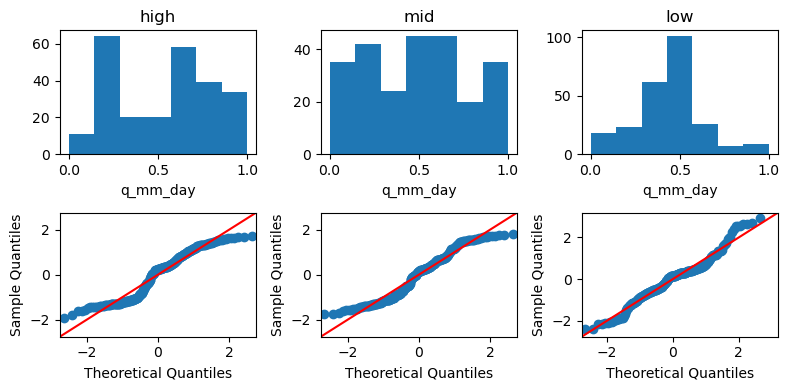

In [79]:
# test for normality 
fig, axs = plt.subplots(ncols=3, nrows=2, tight_layout=True, figsize=(8,4))
val_list = [((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))]
val_title =['high', 'mid', 'low']
for i, val in enumerate(val_list):
    val.plot.hist(ax=axs[0,i], bins=7)
    axs[0,i].set_title(val_title[i])

    sm.qqplot((val-val.mean())/val.std(), line ='45', ax=axs[1,i]);


Fails the Bartlett test which tests for equal variance

In [80]:
stats.bartlett(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min()))),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min()))

<xarray.DataArray 'q_mm_day' (dowy: 246)>
array([5.74392642e-01, 6.10382086e-01, 5.32735608e-01, 5.48752500e-01,
       5.52848543e-01, 6.49761675e-01, 6.25743972e-01, 5.48043096e-01,
       5.42409552e-01, 5.55183914e-01, 5.38633840e-01, 5.12146445e-01,
       4.53781281e-01, 5.04695064e-01, 5.19257414e-01, 4.93173381e-01,
       5.21223085e-01, 5.00570658e-01, 4.77851782e-01, 5.08511567e-01,
       5.05160446e-01, 5.27233602e-01, 5.43152687e-01, 5.24693671e-01,
       5.54807201e-01, 5.56958273e-01, 4.55596803e-01, 5.01233233e-01,
       5.21936585e-01, 5.00693131e-01, 4.81098891e-01, 4.05564235e-01,
       4.63092784e-01, 4.75336861e-01, 4.89353588e-01, 4.88633406e-01,
       5.05853234e-01, 5.22440682e-01, 5.40848085e-01, 4.99150947e-01,
       5.00686326e-01, 5.18026746e-01, 5.74013440e-01, 6.67911612e-01,
       7.07211054e-01, 7.58491080e-01, 7.72177569e-01, 8.25277054e-01,
       8.76951468e-01, 9.34015440e-01, 9.33494270e-01, 9.44681241e-01,
       9.57182681e-01, 1.00000000e+00, 9.44892337e-01, 9.33581598e-01,
       9.02807025e-01, 8.30691566e-01, 8.11327901e-01, 7.69230691e-01,
       7.47066173e-01, 7.07741794e-01, 6.67326626e-01, 7.09955887e-01,
       7.04207275e-01, 6.32396148e-01, 6.07009574e-01, 6.23192068e-01,
       5.82116227e-01, 6.59391986e-01, 6.66665810e-01, 7.00052562e-01,
       6.75871958e-01, 6.47451194e-01, 6.63145113e-01, 6.76602917e-01,
       6.69313293e-01, 6.04372200e-01, 5.54778243e-01, 5.20564392e-01,
...
       3.10778287e-01, 3.21526349e-01, 3.31106695e-01, 3.28851284e-01,
       3.34987504e-01, 3.24783743e-01, 3.42935157e-01, 3.29005915e-01,
       3.47080171e-01, 3.81237676e-01, 4.32553549e-01, 3.87985222e-01,
       3.91438908e-01, 3.99389645e-01, 4.29811072e-01, 4.15404634e-01,
       4.20271092e-01, 4.69481501e-01, 4.81375513e-01, 5.83598832e-01,
       5.22846711e-01, 5.33514348e-01, 5.06003862e-01, 4.85119262e-01,
       5.66076414e-01, 5.32847871e-01, 5.30654413e-01, 4.90580629e-01,
       5.01359947e-01, 5.01506294e-01, 5.36731121e-01, 5.22691326e-01,
       5.24561818e-01, 4.77840234e-01, 4.89033695e-01, 5.89798460e-01,
       4.79447273e-01, 4.79155145e-01, 5.06381031e-01, 4.97886945e-01,
       4.86847737e-01, 5.10283972e-01, 5.42391176e-01, 4.80960321e-01,
       5.16693974e-01, 4.72724473e-01, 4.93211119e-01, 5.10129474e-01,
       5.07604679e-01, 5.06619341e-01, 4.70805619e-01, 5.02367330e-01,
       4.41130469e-01, 3.99521486e-01, 4.34111647e-01, 5.25200369e-01,
       5.60686913e-01, 4.91002666e-01, 4.03094146e-01, 3.49517431e-01,
       3.55696355e-01, 4.58325322e-01, 4.14460135e-01, 4.33264388e-01,
       3.30133639e-01, 3.48490890e-01, 3.06206525e-01, 2.82726773e-01,
       3.66936479e-01, 4.80386079e-01, 4.03298033e-01, 3.61203825e-01,
       3.53705621e-01, 3.66870765e-01, 4.84293811e-01, 4.79282562e-01,
       4.47758002e-01, 3.11576919e-01])
Coordinates:
  * dowy     (dowy) float64 0.0 1.0 2.0 3.0 4.0 ... 362.0 363.0 364.0 365.0

In [81]:
site_diff_high['elevation_cluster'] = 'high'
site_diff_mid['elevation_cluster'] = 'mid'
site_diff_low['elevation_cluster'] = 'low'

In [82]:
df_reshaped = pd.concat([site_diff_high.to_dataframe()[['elevation_cluster','q_mm_day']], 
                         site_diff_mid.to_dataframe()[['elevation_cluster','q_mm_day']],
                         site_diff_low.to_dataframe()[['elevation_cluster','q_mm_day']], 
                         ]).reset_index()
# perform multiple pairwise comparison (Tukey HSD), 
# endog is response variable, groups are the tested groups to compare
period_comp = pairwise_tukeyhsd(endog=df_reshaped['q_mm_day'], groups=df_reshaped['elevation_cluster'], alpha=0.05)

# display the results table
print(period_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  high    low  -0.0724 0.0001 -0.1117 -0.033   True
  high    mid  -0.0233 0.3468 -0.0626 0.0161  False
   low    mid   0.0491 0.0098  0.0097 0.0884   True
---------------------------------------------------


The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post hoc comparisons between groups are required to determine which groups are different.

In [83]:
stats.kruskal(((site_diff_high - site_diff_high.min())/(site_diff_high.max()-site_diff_high.min())),
((site_diff_mid - site_diff_mid.min())/(site_diff_mid.max()-site_diff_mid.min())),
((site_diff_low - site_diff_low.min())/(site_diff_low.max()-site_diff_low.min())))

KruskalResult(statistic=13.579860214429296, pvalue=0.0011250474041236997)